# Imports

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import math
from IPython.core.debugger import set_trace
from IPython.display import display
import umap
import os
from collections import Counter
from IPython.display import clear_output
import urllib.parse
import urllib.request
import requests
import seaborn as sb
import sklearn
from bs4 import BeautifulSoup

# Functions

In [4]:
def export(df, path, h):
    df = df.dropna()
    df.to_csv(path, sep='\t', index=False, header=h)

def import_df(path):
    return pd.read_csv(path, sep='\t', dtype=object)

def transform_id(df):
    df["Protein"] = df["Protein"].map(lambda a: a.split(';')[0])
    
def get_num_cols(df):
    return df.columns[df.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

def comb_lf(df, limited, data_type):
    single_cols = {}
    comb_cols = {}
    col_prefix = ''
    
    # define different column names for the data type
    if data_type == 'prot':
        col_prefix = 'LF'
    else:
        col_prefix = 'P_LF'
    
    # add suffixes based in position as number in pandes columns are ordered differently
    lf1_pos = {
        0: 'a',
        1: 'b',
        2: 'd',
        3: 'f',
        4: 'g',
        5: 'h',
        6: 'i',
        7: 'k',
        8: 'l',
        9: 'm'
    }
    lf2_pos = {1: 'c', 2: 'e', 6: 'j'}
    
    for i in range(0, 10):
        # combining duplicate batches with geometric mean
        if i in [0, 3, 4, 5, 7, 8, 9]:
            comb_cols['time point %s' % lf1_pos.get(i)] = []
            for v1, v2 in list(
                    zip(df['Reporter.intensity.{}.{}1'.format(i, col_prefix)],
                        df['Reporter.intensity.{}.{}2'.format(i, col_prefix)])):
                comb_cols['time point %s' % lf1_pos.get(i)].append(
                    np.sqrt((float(v1) * float(v2))))
        elif (not limited):
            # not limited i.e. keep the duplicate columns separated
            single_cols['time point %s' % lf1_pos.get(i)] = df['Reporter.intensity.{}.{}1'.format(i, col_prefix)].values
            single_cols['time point %s' % lf2_pos.get(i)] = df['Reporter.intensity.{}.{}2'.format(i, col_prefix)].values

    res = pd.DataFrame(comb_cols)
    if (not limited):
        res = res.join(pd.DataFrame(single_cols))
    res = res.reindex(sorted(res.columns), axis=1)

    return res

print('loading filter table')
def filter_table(df, data_type):
    print('Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant')
    # remove unwanted rows
    if data_type == 'prot':
        df = df[df['Only identified by site'] != '+']  #remove proteins only identified by site
    
    df = df[df['Reverse'] != '+']  #remove proteins which matched on a reverse sequence
    df = df[df['Potential contaminant'] != '+']  #remove proteins which could be a contaminant
    df.reset_index(inplace=True, drop=True)
    
    return df
    
print('loading map to ppi')
def map_to_ppi(df, ppi_set):
    print('Removing all proteins which are not present in the ppi network.')
    drops = []
    drop_count = 0
    for i in df['Protein']:
        if i not in ppi_set:
            drops.append(drop_count)
        drop_count += 1

    print('%s proteins not found in ppi.' % len(drops))
    df = df.drop(df.index[drops], axis=0)
    print('%s proteins left.' % len(df))
        
    return df

## init colors ##
# create a distinct colormap from the rainbow colormap
print('init colors')
colormap = plt.cm.get_cmap('rainbow')
colors = []
for i in range(40,235,15):
    colors.append(colormap(i))
####

print('loading abs_sum_diff')
def abs_sum_diff(raw_df):
    """
    Calculate the aboslute sum of difference for each row of a pandas data frame.
    return : pandas data frame
    """
    df = raw_df.copy()
    del df['Protein']
    del df['sample']
    
    diff_sum_list = []
    
    for index, row in df.iterrows():
        diff_sum = 0
        for i in range(len(row)-1): 
            if isinstance(row[i], str): # check if value is numeric 
                continue
            
            diff_sum += abs(row[i+1]-row[i])
            
        diff_sum_list.append(diff_sum)

    return pd.DataFrame(diff_sum_list) # return data frame from list of differences

print('loading: build_sample')
def build_sample(df, unq_id):
    """
    Add a sample number column to the given pandas data frame
    """
    id_count = {}
    samples = []
    new_ids = []
    
    for i in df["Protein"]:
        if i not in id_count:
            id_count[i] = 1 # count number of times the id was found
        else:
            id_count[i] = id_count.get(i) + 1
        # build sample column
        samples.append('%s' % id_count.get(i))
        if unq_id:
            new_ids.append('%s.%s' % (i,id_count.get(i)))
        
    df['sample'] = samples

def logfc_series(expr_series):
    """
    Calculate the log2 fold change of a given pandas series.
    """
    expr_series = expr_series.reset_index(drop=True)
    expr_series += 1
    row_fc = []
    for i in range(len(expr_series)-1):
        fc = np.divide(expr_series[i+1], expr_series[i])
        row_fc.append(np.abs(fc))
    prot_logfc = pd.Series(row_fc, index = ['LFC_{}-{}'.format(i, i+1) for i in range(len(expr_series)-1)])
    prot_logfc = prot_logfc.apply(lambda x : np.log2(x))
    return prot_logfc

print('-- methods loaded --')

loading filter table
loading map to ppi
init colors
loading abs_sum_diff
loading: build_sample
-- methods loaded --


# Plots

## Box Plots of Expression Values

In [19]:
def boxplot_expression(raw_df, path, title_addition):
    """
    Create a box plot from a pandas data frame
    """
    df = raw_df.copy()
    del df['Protein']
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Time Points', fontsize=15)
    ax.set_ylabel('Peptide Counts', fontsize=15)
    ax.set_title('Box Plot of Expression per Time Point\n{}'.format(title_addition), fontsize=20)
    ax.set_xticklabels(range(0,len(df.columns)))
    ax.set_yscale('log')
    
    df.boxplot(ax = ax, fontsize = 8)
    ax.set_xticklabels(range(len(df)))
    if path != '':
        plt.savefig(path=path, dpi=100)
    
    plt.show()

### Proteomics

#### EB

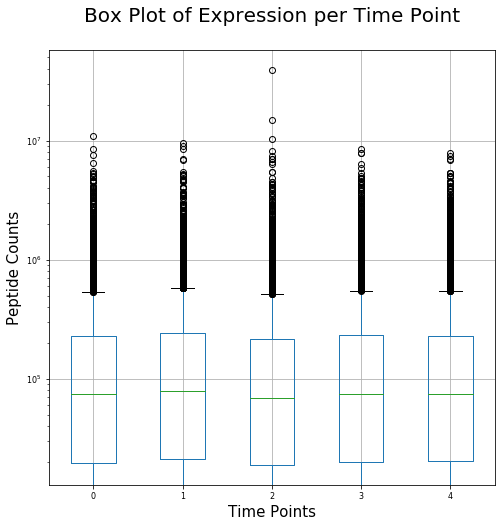

In [20]:
boxplot_expression(protEB, '', '')

#### FL

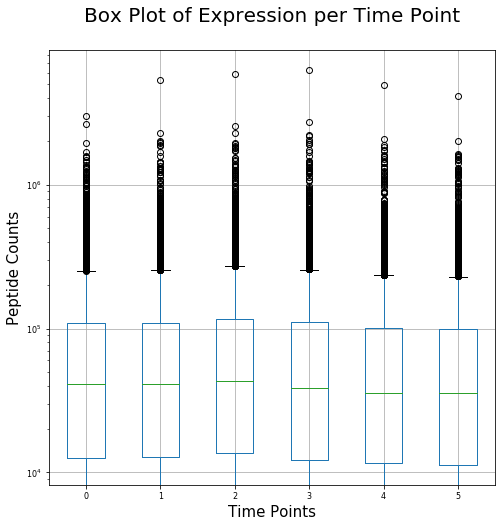

In [22]:
boxplot_expression(protFL, '','')

#### LF

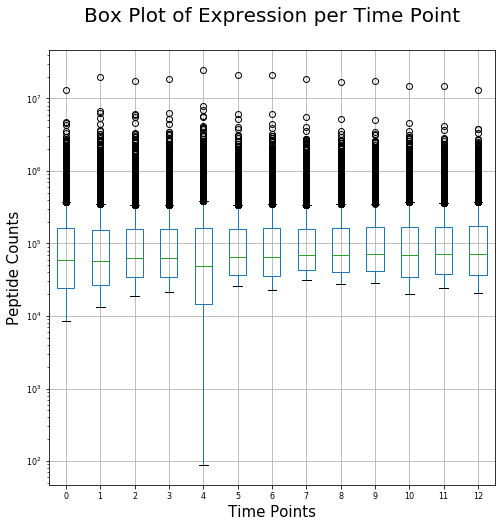

In [23]:
boxplot_expression(protLF, '','')

#### SQ

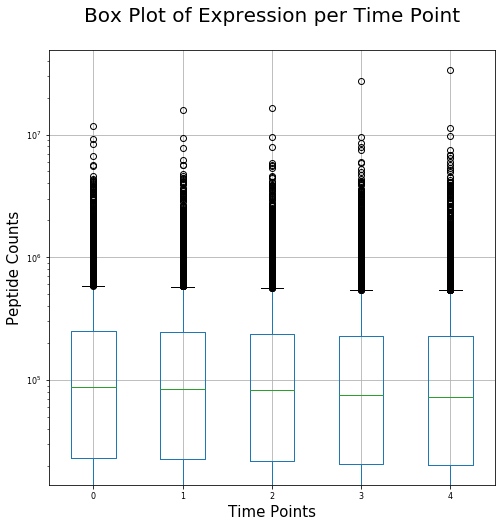

In [25]:
boxplot_expression(protSQ, '', '')

#### Facet

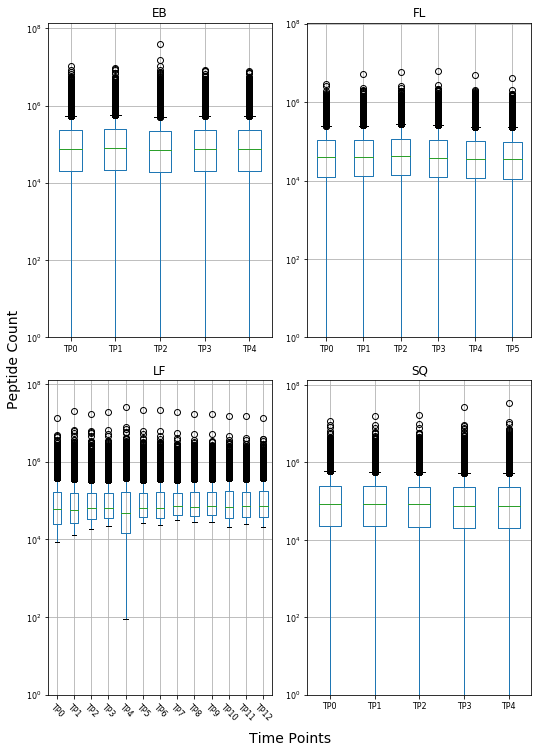

In [27]:
# Create figure
fig = plt.figure(figsize=(8,11))
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

# add eb boxplot
ax1.set(title='EB')
ax1.set_yscale('log')
protEB.columns = ['PID'] + ['TP{}'.format(x) for x in range(len(protEB.columns)-1)]
ax1.set_ylim([1,protEB.max()[1:].max()+10**8])
protEB.boxplot(ax= ax1, fontsize = 8)

#add fl boxplot
ax2.set(title='FL')
ax2.set_yscale('log')
protFL.columns = ['PID'] + ['TP{}'.format(x) for x in range(len(protFL.columns)-1)]
ax2.set_ylim([1,protFL.max()[1:].max()+10**8])
protFL.iloc[:,1:].boxplot(ax= ax2, fontsize= 8)

ax3.set(title='LF')
ax3.set_yscale('log')
protLF.columns = ['PID'] + ['TP{}'.format(x) for x in range(len(protLF.columns)-1)]
ax3.set_ylim([1,protLF.max()[1:].max()+10**8])
protLF.iloc[:,1:].boxplot(ax= ax3, fontsize= 8)
ax3.set_xticklabels(labels= protLF.columns.tolist()[1:], rotation=-45)

ax4.set(title='SQ')
ax4.set_yscale('log')
protSQ.columns = ['PID'] + ['TP{}'.format(x) for x in range(len(protSQ.columns)-1)]
ax4.set_ylim([1,protSQ.max()[1:].max()+10**8])
protSQ.iloc[:,1:].boxplot(ax= ax4, fontsize= 8)

ax.set_xlabel('Time Points', fontsize= 14)
ax.xaxis.labelpad = 20
ax.set_ylabel('Peptide Count', fontsize= 14)

fig.tight_layout()
plt.savefig('./Plots/FacetRawProt.png',dpi=300, bbox_inches='tight')
plt.show()

### Phosphoproteomics

#### EB

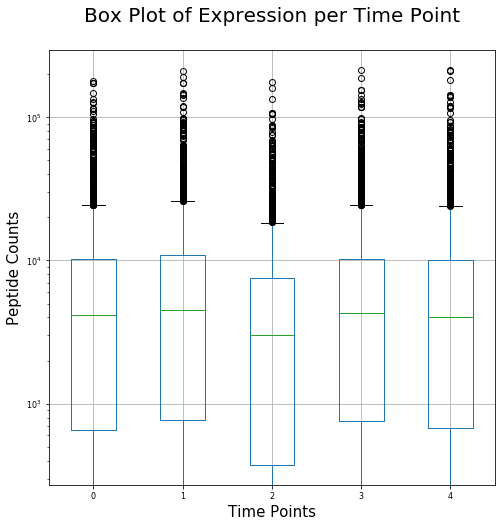

In [28]:
boxplot_expression(phosEB,'','')

#### FL

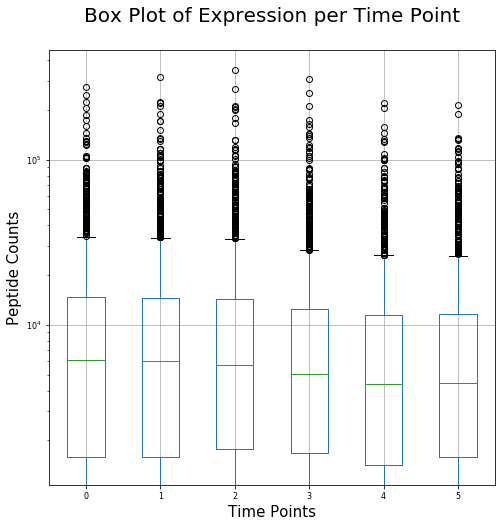

In [29]:
boxplot_expression(phosFL, '','')

#### LF

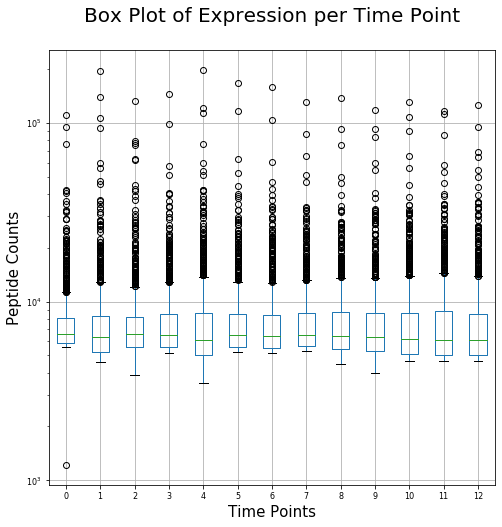

In [30]:
boxplot_expression(phosLF, '', '')

#### SQ

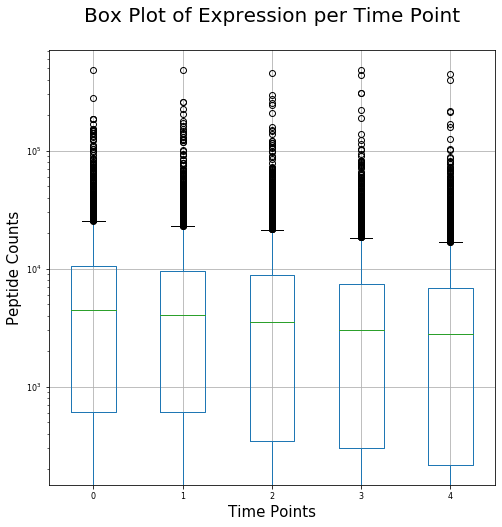

In [31]:
boxplot_expression(phosSQ,'','')

#### Facet

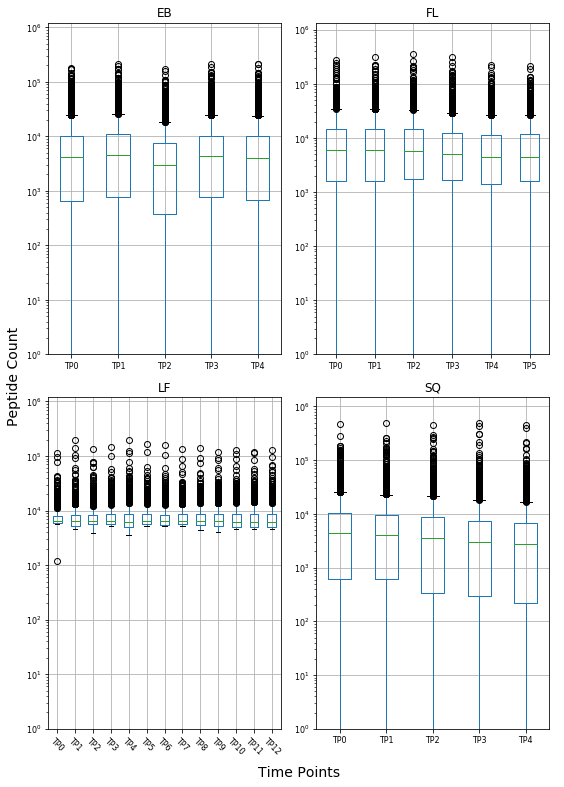

In [32]:
# Create figure
fig = plt.figure(figsize=(8,11))
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

# add eb boxplot
ax1.set(title='EB')
ax1.set_yscale('log')
phosEB.columns = ['PID'] + ['TP{}'.format(x) for x in range(len(phosEB.columns)-1)]
ax1.set_ylim([1,phosEB.max()[1:].max()+10**6])
phosEB.boxplot(ax= ax1, fontsize = 8)

#add fl boxplot
ax2.set(title='FL')
ax2.set_yscale('log')
phosFL.columns = ['PID'] + ['TP{}'.format(x) for x in range(len(phosFL.columns)-1)]
ax2.set_ylim([1,phosFL.max()[1:].max()+10**6])
phosFL.boxplot(ax= ax2, fontsize= 8)

ax3.set(title='LF')
ax3.set_yscale('log')
phosLF.columns = ['PID'] + ['TP{}'.format(x) for x in range(len(phosLF.columns)-1)]
ax3.set_ylim(1, phosLF.max()[1:].max()+10**6)
phosLF.boxplot(ax= ax3, fontsize= 8)
ax3.set_xticklabels(labels= protLF.columns.tolist()[1:], rotation=-45)

ax4.set(title='SQ')
ax4.set_yscale('log')
phosSQ.columns = ['PID'] + ['TP{}'.format(x) for x in range(len(phosSQ.columns)-1)]
ax4.set_ylim([1,phosSQ.max()[1:].max()+10**6])
phosSQ.boxplot(ax= ax4, fontsize= 8)

fig.tight_layout()

ax.set_xlabel('Time Points', fontsize= 14)
ax.xaxis.labelpad = 20
ax.set_ylabel('Peptide Count', fontsize= 14)

plt.savefig('./Plots/FacetRawPhos.png',dpi=300, bbox_inches='tight')

plt.show()

## UMAP

### Functions

In [29]:
def plotUmapUncorrected(embedding, ax= None):
    """
    Create scatter plot of the umap projection in the given embedding of the not batch corrected data.
    """
    colormap = plt.cm.get_cmap('rainbow')
    colors = []
    for i in range(40,235,15):
        colors.append(colormap(i))

    if ax == None:
        print('Axis missing for facet plot integration. Falling back on singular plot.')
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1)
    
    # converseion from table position to actual time point
    lf_color_lookup = {0:0 ,1:1 ,2:3 ,3: 5 ,4: 6 ,5: 7 ,6: 8 ,7: 10 ,8: 11 ,9:12 ,
                      10: 0 ,11: 2 ,12: 4 ,13: 5 ,14: 6 ,15: 7 ,16:9 ,17: 10 ,18: 11 , 19: 12}

    for e in range(len(embedding)):
        # select appropriate marker and color for each time point
        if 0 <= e and e <= 4:
            ax.scatter(embedding[e][0],
                       embedding[e][1],
                       marker='^',
                       color=colors[e])
        elif 5 <= e and e <= 10:
            ax.scatter(embedding[e][0],
                       embedding[e][1],
                       marker='s',
                       color=colors[e - 5])
        elif 11 <= e and e <= 30:
            ax.scatter(embedding[e][0],
                       embedding[e][1],
                       marker='h',
                       color= colors[lf_color_lookup.get(e-11)])
        else:
            ax.scatter(embedding[e][0],
                       embedding[e][1],
                       marker='D',
                       color=colors[e - 31])
            
    if ax == None: # if not used as a subplot create own figure
        # add marker for tissues
        EB_marker = mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=10, label='EB')
        FL_marker = mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=10, label='FL')
        LF_marker = mlines.Line2D([], [], color='black', marker='h', linestyle='None', markersize=10, label='LF')
        SQ_marker = mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=10, label='SQ')

        # but tissue markers to correct position
        tissue_legend = ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,
                                  handles=[EB_marker ,FL_marker ,LF_marker ,SQ_marker],
                                  title='Tissues',prop={'size': 12})
        fig.gca().add_artist(tissue_legend)
        markers=[]
        for i in range(13):
            # add markers for time points
            markers.append(mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None', markersize=10, label='{}'.format(i)))
        ax.legend(bbox_to_anchor=(1.01, 0.8), loc=2, borderaxespad=0., handles=markers, title='Time Points', prop={'size': 12})
        
        plt.show()

    
def plotUmapCorrected(df, ax= None):
    """
    Create a scater plot of a umap embedding of the corrected data
    """
    colormap = plt.cm.get_cmap('rainbow')
    colors = []
    for i in range(40,235,15):
        colors.append(colormap(i))
        
    if ax == None:
        print('Axis missing for facet plot integration. Falling back on singular plot.')
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1)
    
    for e in range(len(df)):
        # select appropriate marker and color for each time point
        if 0 <= e and e <= 4:
            ax.scatter(df[e][0],
                       df[e][1],
                       marker='^',
                       color=colors[e])
        elif 5 <= e and e <= 10:
            ax.scatter(df[e][0],
                           df[e][1],
                           marker='s',
                           color=colors[e - 5])
        elif 11 <= e and e <= 23:
            ax.scatter(df[e][0],
                       df[e][1],
                       marker='h',
                       color=colors[e-11])
        else:
            ax.scatter(df[e][0],
                       df[e][1],
                       marker='D',
                       color=colors[e - 24])
    if ax == None:
        LF_marker = mlines.Line2D([], [], color='black', marker='h', linestyle='None', markersize=10, label='LF')
        EB_marker = mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=10, label='EB')
        FL_marker = mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=10, label='FL')
        SQ_marker = mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=10, label='SQ')

        marker_legend = ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,
                                  handles=[EB_marker, FL_marker, LF_marker, SQ_marker],
                                  title='Tissues',prop={'size': 13})
        fig.gca().add_artist(marker_legend)

        markers=[]
        for i in range(13):
            markers.append(mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None', markersize=10, label='{}'.format(i)))
        ax.legend(bbox_to_anchor=(1.01, 0.8), loc=2, borderaxespad=0., handles=markers, title='Time Points', prop={'size': 12})
        
        plt.show()
        
def plotUmapComparison(embedding_corrected, embedding_uncorrected):
    """
    Create a facet plot of two umap projection scatter plots
    """
    
    fig = plt.figure(figsize=(8,7))
    ax = fig.add_subplot(111)    # The big subplot
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    
    plotUmapCorrected(embedding_corrected, ax1)
    plotUmapUncorrected(embedding_uncorrected, ax2)
    
    EB_marker = mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=10, label='EB')
    FL_marker = mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=10, label='FL')
    LF_marker = mlines.Line2D([], [], color='black', marker='h', linestyle='None', markersize=10, label='LF')
    SQ_marker = mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=10, label='SQ')

    tissue_legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,
                              handles=[EB_marker ,FL_marker ,LF_marker ,SQ_marker],
                              title='Tissues',prop={'size': 12})
    plt.gca().add_artist(tissue_legend)
    markers=[]
    for i in range(13):
        markers.append(mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None', markersize=10, label='{}'.format(i)))
    plt.legend(bbox_to_anchor=(1.01, 0.7), loc=2, borderaxespad=0., handles=markers, title='Time Points', prop={'size': 12})
    
    ax.set_xlabel('UMAP 1', fontsize= 14)
    ax.set_ylabel('UMAP 2', fontsize= 14)
    plt.show()


### Plots
Proteomics

In [11]:
protEB, protFL, protLF, protSQ = pipeline(data_type='prot',
                                          string_cut= -1,
                                          square_data=False, 
                                          normalize = False,
                                          combine= True,
                                          as_env_var=True)

# combine tables to have one concise table
corrected_prot = protEB.merge(protFL, how='inner', on='Protein')
corrected_prot = corrected_prot.merge(protLF, how='inner', on='Protein')
corrected_prot = corrected_prot.merge(protSQ, how='inner', on='Protein')
del corrected_prot['Protein']

protEB, protFL, protLF, protSQ = pipeline(data_type='prot',
                                          string_cut= -1,
                                          square_data=False, 
                                          normalize = False,
                                          combine= False,
                                          as_env_var=True)

# combine tables to have one concise table
uncorrected_prot = protEB.merge(protFL, how='inner', on='Protein')
uncorrected_prot = uncorrected_prot.merge(protLF, how='inner', on='Protein')
uncorrected_prot = uncorrected_prot.merge(protSQ, how='inner', on='Protein')
del uncorrected_prot['Protein']

Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
copying IDs
removing non majority protein ids.
adding expression values to tables containing ids
Number of proteins left after MaxQuant filtering:
EB: 12852
FL: 11364
LF: 10465
SQ: 12852

finished
Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
copying IDs
removing non majority p

In [80]:
embedding_uncorr = umap.UMAP(n_neighbors=12,
                      min_dist=0.1,
            ).fit_transform(uncorrected_prot.T.values)

embedding_corr = umap.UMAP(n_neighbors=12,
                      min_dist=0.1,
            ).fit_transform(corrected_prot.T.values)

/home/thibault/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


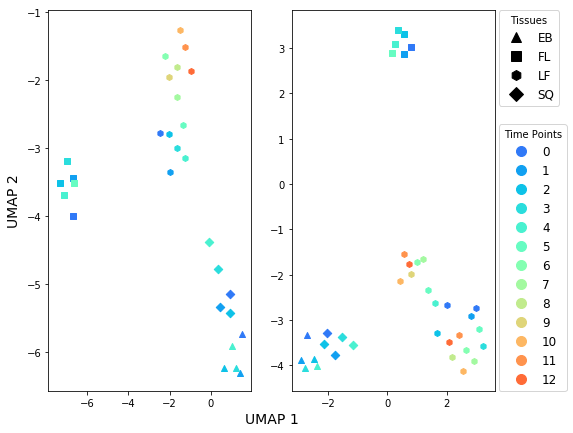

In [81]:
plotUmapComparison(embedding_corr, embedding_uncorr)

Phosphoproteomics

In [82]:
phosEB, phosFL, phosLF, phosSQ = pipeline(data_type='phos',
                                          string_cut= -1,
                                          square_data=False, 
                                          normalize = False,
                                          combine= True,
                                          as_env_var=True)

corrected_phos = phosEB.merge(phosFL, how='inner', on='Protein')
corrected_phos = corrected_phos.merge(phosLF, how='inner', on='Protein')
corrected_phos = corrected_phos.merge(phosSQ, how='inner', on='Protein')
del corrected_phos['Protein']

phosEB, phosFL, phosLF, phosSQ = pipeline(data_type='phos',
                                          string_cut= -1,
                                          square_data=False, 
                                          normalize = False,
                                          combine= False,
                                          as_env_var=True)

uncorrected_phos = phosEB.merge(phosFL, how='inner', on='Protein')
uncorrected_phos = uncorrected_phos.merge(phosLF, how='inner', on='Protein')
uncorrected_phos = uncorrected_phos.merge(phosSQ, how='inner', on='Protein')
del uncorrected_phos['Protein']

Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
adding expression values to tables containing ids
Number of peptides left after MaxQuant filtering:
EB: 6659
FL: 3411
LF: 2372
SQ: 6659

finished
Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
adding expression values to tables containing ids
Number of peptides left after MaxQua

In [97]:
embedding_uncorr = umap.UMAP(n_neighbors=12,
                      min_dist=0.1,
            ).fit_transform(uncorrected_phos.T.values)

embedding_corr = umap.UMAP(n_neighbors=12,
                      min_dist=0.1,
            ).fit_transform(corrected_phos.T.values)

/home/thibault/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


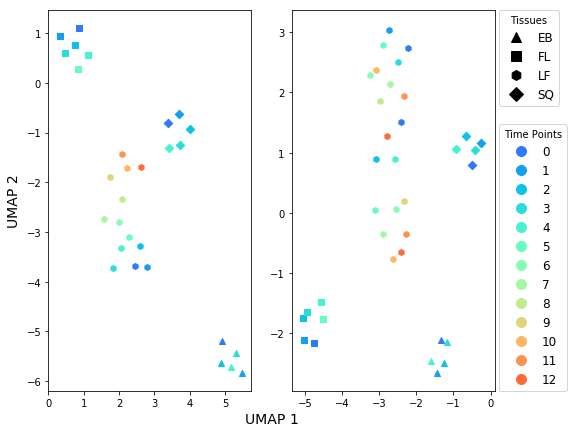

In [98]:
plotUmapComparison(embedding_corr, embedding_uncorr)

## GO Enriched Term Statistics

### Bar Plots of Categories with most Proteins Associated

In [74]:
def axTermNumBar(name, ax):
    """
    Create a bar plot of the number of go terms and select the ten largest
    """
    term_table = pd.DataFrame(columns=['UIDS'])
    bingo_table = pd.read_csv('./Data/GO_Enrichment/tables/{}_GO_P.csv'.format(name), sep='\t')
    
    term_table[name] = bingo_table.iloc[:,1]
    term_table['UIDS'] = bingo_table.iloc[:,-1]
    
    term_table = term_table.set_index([name])
    term_table = term_table.applymap(lambda x: len(x.split()))
    termsum = term_table['UIDS'].sum()
    term_table['UIDS'] = (term_table['UIDS']/termsum) * 100
    term_table = term_table.sort_values(by= ['UIDS'], ascending= False)
    
    ax.set_ylabel(name, size= 14)
    term_table.iloc[:10,:].sort_values(by= ['UIDS'], ascending= True).plot.barh(ax= ax)

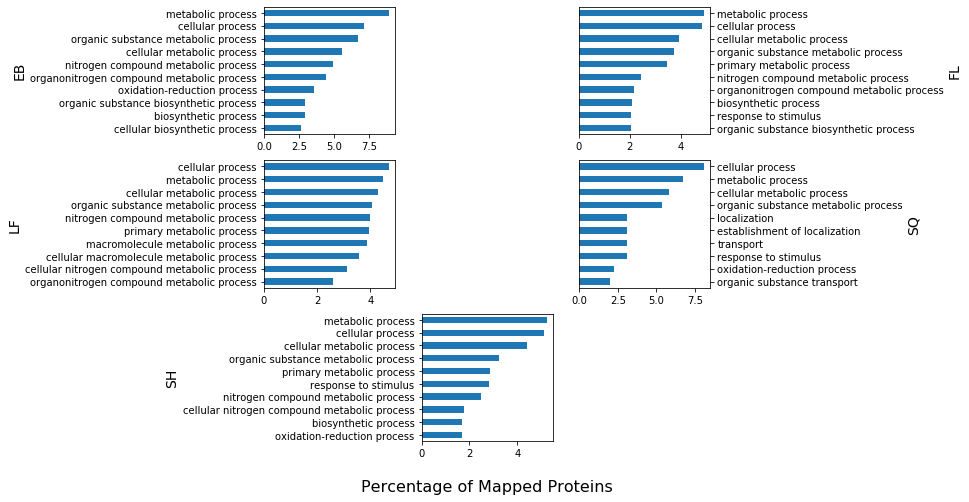

In [75]:
fig = plt.figure(figsize=(8, 8))
ax_EB = fig.add_subplot(3, 3, 1)
ax_FL = fig.add_subplot(3, 3, 3)
ax_LF = fig.add_subplot(3, 3, 4)
ax_SQ = fig.add_subplot(3, 3, 6)
ax_SH = fig.add_subplot(3, 3, 8)

axTermNumBar('EB', ax_EB)
axTermNumBar('FL', ax_FL)
axTermNumBar('LF', ax_LF)
axTermNumBar('SQ', ax_SQ)
axTermNumBar('SH', ax_SH)

ax_EB.legend_.remove()
ax_FL.legend_.remove()
ax_LF.legend_.remove()
ax_SQ.legend_.remove()
ax_SH.legend_.remove()

ax_FL.yaxis.set_label_position("right")
ax_FL.yaxis.tick_right()
ax_SQ.yaxis.set_label_position("right")
ax_SQ.yaxis.tick_right()

ax_SH.set_xlabel('Percentage of Mapped Proteins', size= 16)
ax_SH.get_xaxis().set_label_coords(0.5, -0.3)

plt.savefig('./Plots/termbar.png', dpi=200, bbox_inches='tight')
plt.show()


### Bar Plots for Most Significant Terms

In [5]:
def axTermSigBar (name, ax):
    """
    Create a bar plot of the significance of go terms and select the ten largest
    """
    term_table = pd.DataFrame(columns=['FDR'])
    bingo_table = pd.read_csv('./Data/GO_Enrichment/tables/{}_GO_P.csv'.format(name), sep='\t')
    
    term_table[name] = bingo_table.iloc[:,1]
    term_table['FDR'] = bingo_table.iloc[:,-2]
    
    term_table = term_table.set_index([name])
    term_table = term_table.sort_values(by= ['FDR'], ascending= True)
    
    ax.set_xscale('log')
    ax.set_ylabel(name, size= 14)
    term_table.iloc[:10,:].sort_values(by= ['FDR'], ascending= False).plot.barh(ax= ax)

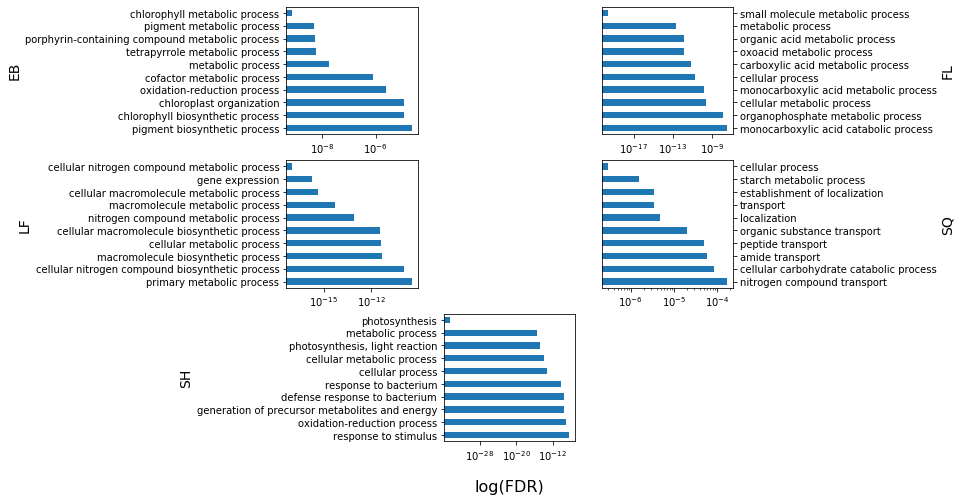

In [6]:
fig = plt.figure(figsize=(8, 8))
ax_EB = fig.add_subplot(3, 3, 1)
ax_FL = fig.add_subplot(3, 3, 3)
ax_LF = fig.add_subplot(3, 3, 4)
ax_SQ = fig.add_subplot(3, 3, 6)
ax_SH = fig.add_subplot(3, 3, 8)

axTermSigBar('EB', ax_EB)
axTermSigBar('FL', ax_FL)
axTermSigBar('LF', ax_LF)
axTermSigBar('SQ', ax_SQ)
axTermSigBar('SH', ax_SH)

ax_EB.legend_.remove()
ax_FL.legend_.remove()
ax_LF.legend_.remove()
ax_SQ.legend_.remove()
ax_SH.legend_.remove()

ax_FL.yaxis.set_label_position("right")
ax_FL.yaxis.tick_right()
ax_SQ.yaxis.set_label_position("right")
ax_SQ.yaxis.tick_right()

ax_SH.set_xlabel('log(FDR)', size= 16)
ax_SH.get_xaxis().set_label_coords(0.5, -0.3)

plt.savefig('./Plots/sigbar.png', dpi=200, bbox_inches='tight')
plt.show()


### Bar Plots for Most Abundant Terms per Cluster.

In [84]:
def axClustTermNumBar(bingo_table, node_table, axs):
    """
    Create a bar plot of the number of go terms and select the ten largest for each cluster
    """
    term_table = pd.DataFrame(columns=['UID', 'TERM', 'CLUSTER'])
    node_table = node_table.set_index(['UNIPROTID'])
        
    for row in bingo_table.itertuples(index=False):
        for uid in row[-1].split():
            term_table = term_table.append(pd.Series({'UID': uid, 'TERM': row[1], 'CLUSTER': int(node_table.loc[uid]['CLUSTER'])}), ignore_index=True)
    
    clusts = sorted(term_table['CLUSTER'].unique().tolist())
    for i in clusts:
        tmp = term_table.loc[term_table['CLUSTER'] == i]
        term_count = pd.DataFrame.from_dict(Counter(tmp['TERM']), orient='index')
        
        termsum = sum(term_count[0])
        term_count[0] = (term_count[0]/termsum)*100 # calculate percentage of mapped proteins
        
        term_count = term_count.sort_values(by= [0], ascending= False)
                
        ax = axs[clusts.index(i)]
        term_count.iloc[:10,:].sort_values(by= [0], ascending= True).plot.barh(ax= ax)
        ax.set_ylabel('Cluster {}'.format(i), size= 14)
        ax.legend_.remove()

EB

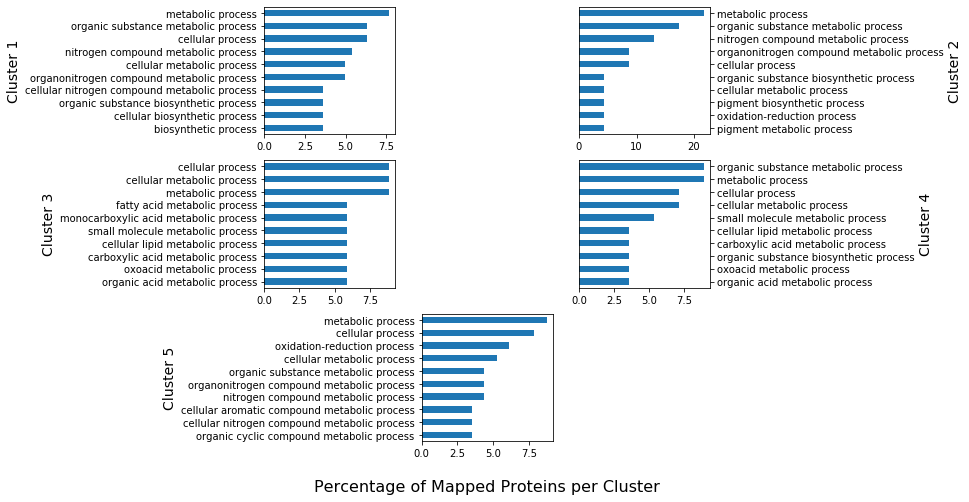

In [85]:
name = 'EB'
node_table = pd.read_csv('./Data/NodeTables/node_table_{}.tsv'.format(name), sep='\t')
bingo_table = pd.read_csv('./Data/GO_Enrichment/tables/{}_GO_P.csv'.format(name), sep='\t')

fig = plt.figure(figsize=(8, 8))

ax_cl1 = fig.add_subplot(3, 3, 1)
ax_cl2 = fig.add_subplot(3, 3, 3)
ax_cl3 = fig.add_subplot(3, 3, 4)
ax_cl4 = fig.add_subplot(3, 3, 6)
ax_cl5 = fig.add_subplot(3, 3, 8)

axClustTermNumBar(bingo_table, node_table, [ax_cl1, ax_cl2, ax_cl3, ax_cl4, ax_cl5])

ax_cl2.yaxis.set_label_position("right")
ax_cl2.yaxis.tick_right()
ax_cl4.yaxis.set_label_position("right")
ax_cl4.yaxis.tick_right()

ax_cl5.set_xlabel('Percentage of Mapped Proteins per Cluster', size= 16)
ax_cl5.get_xaxis().set_label_coords(0.5, -0.3)

plt.savefig('/home/thibault/Documents/bachelorarbeit/Plots/{}_ClusTermCount.png'.format(name), dpi=200, bbox_inches='tight')
plt.show()

FL

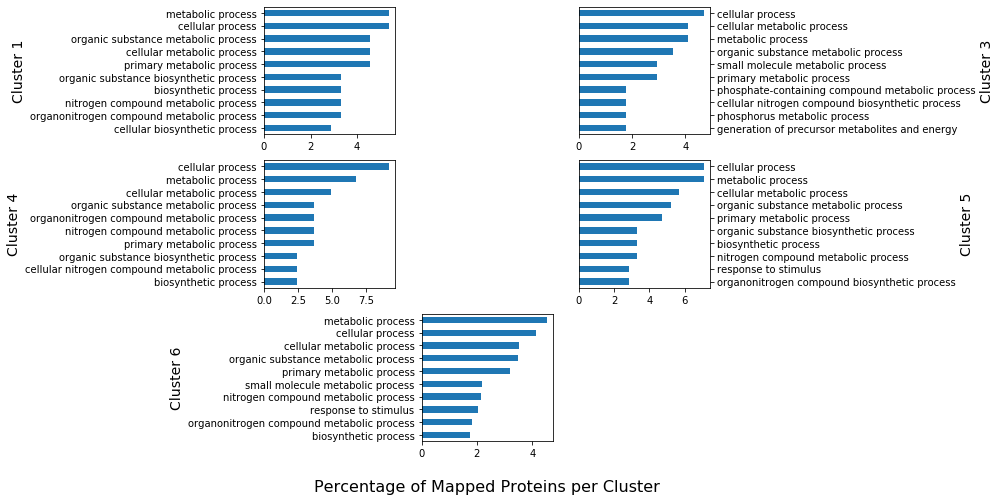

In [86]:
name = 'FL'
node_table = pd.read_csv('./Data/NodeTables/node_table_{}.tsv'.format(name), sep='\t')
bingo_table = pd.read_csv('./Data/GO_Enrichment/tables/{}_GO_P.csv'.format(name), sep='\t')

fig = plt.figure(figsize=(8, 8))

ax_cl1 = fig.add_subplot(3, 3, 1)
ax_cl2 = fig.add_subplot(3, 3, 3)
ax_cl3 = fig.add_subplot(3, 3, 4)
ax_cl4 = fig.add_subplot(3, 3, 6)
ax_cl5 = fig.add_subplot(3, 3, 8)

axClustTermNumBar(bingo_table, node_table, [ax_cl1, ax_cl2, ax_cl3, ax_cl4, ax_cl5])

ax_cl2.yaxis.set_label_position("right")
ax_cl2.yaxis.tick_right()
ax_cl4.yaxis.set_label_position("right")
ax_cl4.yaxis.tick_right()

ax_cl5.set_xlabel('Percentage of Mapped Proteins per Cluster', size= 16)
ax_cl5.get_xaxis().set_label_coords(0.5, -0.3)

plt.savefig('./Plots/{}_ClusTermCount.png'.format(name), dpi=200, bbox_inches='tight')
plt.show()

LF

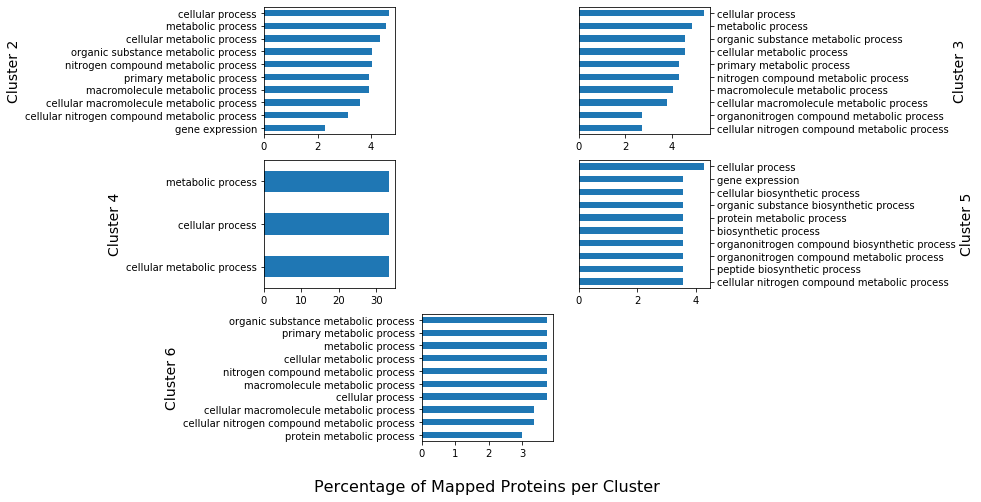

In [87]:
name = 'LF'
node_table = pd.read_csv('./Data/NodeTables/node_table_{}.tsv'.format(name), sep='\t')
bingo_table = pd.read_csv('./Data/GO_Enrichment/tables/{}_GO_P.csv'.format(name), sep='\t')

fig = plt.figure(figsize=(8, 8))

ax_cl1 = fig.add_subplot(3, 3, 1)
ax_cl2 = fig.add_subplot(3, 3, 3)
ax_cl3 = fig.add_subplot(3, 3, 4)
ax_cl4 = fig.add_subplot(3, 3, 6)
ax_cl5 = fig.add_subplot(3, 3, 8)

axClustTermNumBar(bingo_table, node_table, [ax_cl1, ax_cl2, ax_cl3, ax_cl4, ax_cl5])

ax_cl2.yaxis.set_label_position("right")
ax_cl2.yaxis.tick_right()
ax_cl4.yaxis.set_label_position("right")
ax_cl4.yaxis.tick_right()

ax_cl5.set_xlabel('Percentage of Mapped Proteins per Cluster', size= 16)
ax_cl5.get_xaxis().set_label_coords(0.5, -0.3)

plt.savefig('./Plots/{}_ClusTermCount.png'.format(name), dpi=200, bbox_inches='tight')
plt.show()

SQ

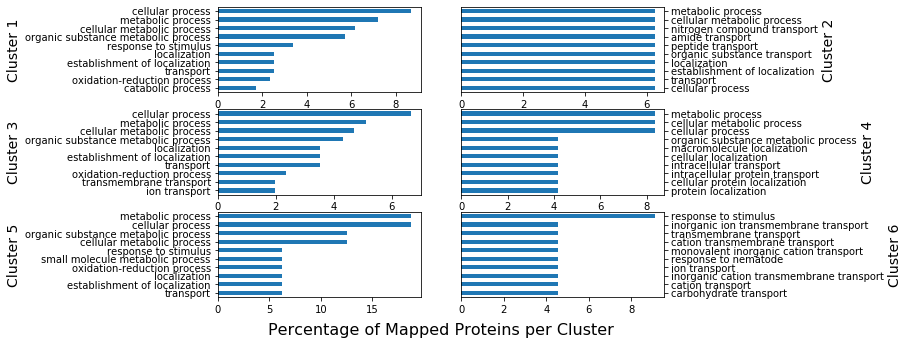

In [88]:
name = 'SQ'
node_table = pd.read_csv('./Data/NodeTables/node_table_{}.tsv'.format(name), sep='\t')
bingo_table = pd.read_csv('./Data/GO_Enrichment/tables/{}_GO_P.csv'.format(name), sep='\t')

fig = plt.figure(figsize=(8, 11))

ax_cl1 = fig.add_subplot(6, 2, 1)
ax_cl2 = fig.add_subplot(6, 2, 2)
ax_cl3 = fig.add_subplot(6, 2, 3)
ax_cl4 = fig.add_subplot(6, 2, 4)
ax_cl5 = fig.add_subplot(6, 2, 5)
ax_cl6 = fig.add_subplot(6, 2, 6)

axClustTermNumBar(bingo_table, node_table, [ax_cl1, ax_cl2, ax_cl3, ax_cl4, ax_cl5, ax_cl6])

ax_cl2.yaxis.set_label_position("right")
ax_cl2.yaxis.tick_right()
ax_cl4.yaxis.set_label_position("right")
ax_cl4.yaxis.tick_right()
ax_cl6.yaxis.set_label_position("right")
ax_cl6.yaxis.tick_right()

ax_cl6.set_xlabel('Percentage of Mapped Proteins per Cluster', size= 16)
ax_cl6.get_xaxis().set_label_coords(-0.1, -0.3)

plt.savefig('./Plots/{}_ClusTermCount.png'.format(name), dpi=200, bbox_inches='tight')
plt.show()

### Bar Plots for Most Significant Terms per Cluster

In [36]:
def axClustTermSigBar(bingo_table, node_table, axs):
    """
    Create a bar plot of the number of go terms and select the ten largest for each cluster
    """
    term_table = pd.DataFrame(columns=['UID', 'TERM', 'CLUSTER', 'FDR'])
    node_table = node_table.set_index(['UNIPROTID'])
    
    for row in bingo_table.itertuples(index=False):
        for uid in row[-1].split():
            term_table = term_table.append(pd.Series({'UID': uid, 'TERM': row[1], 'CLUSTER': int(node_table.loc[uid]['CLUSTER']), 'FDR': row[-2]}), ignore_index=True)
    
    clusts = sorted(term_table['CLUSTER'].unique().tolist())

    for i in clusts:
        tmp = term_table.loc[term_table['CLUSTER'] == i]
        ax = axs[clusts.index(i)]
        ax.set_xscale('log')
        tmp = tmp.sort_values(by= ['FDR'], ascending= True)
        tmp = tmp.drop_duplicates(subset= ['FDR'])
        
        del tmp['UID']
        del tmp['CLUSTER']
        tmp = tmp.set_index(['TERM'])
        
        tmp.iloc[:10,:].sort_values(by= ['FDR'], ascending= False).plot.barh(ax= ax)
        ax.set_ylabel('Cluster {}'.format(i), size= 14)
        ax.legend_.remove()

EB

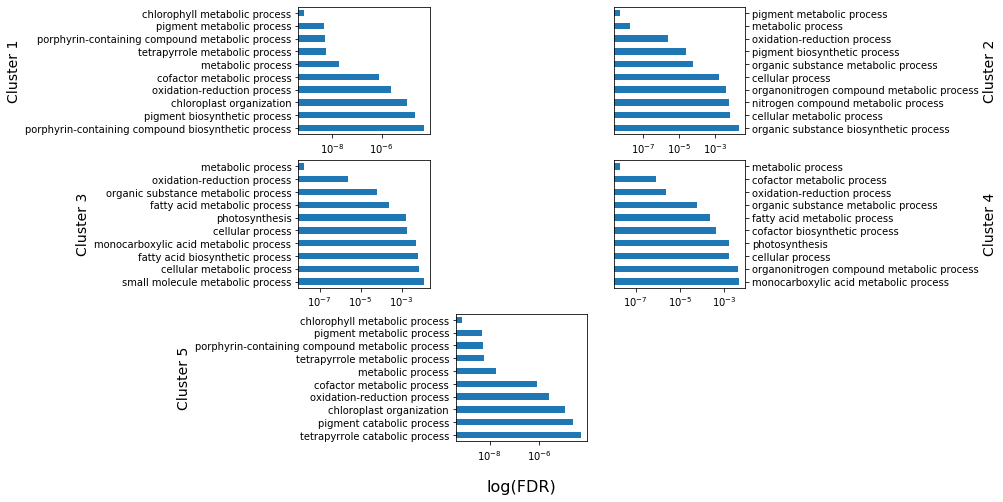

In [37]:
name = 'EB'
node_table = pd.read_csv('./Data/NodeTables/node_table_{}.tsv'.format(name), sep='\t')
bingo_table = pd.read_csv('./Data/GO_Enrichment/tables/{}_GO_P.csv'.format(name), sep='\t')

fig = plt.figure(figsize=(8, 8))

ax_cl1 = fig.add_subplot(3, 3, 1)
ax_cl2 = fig.add_subplot(3, 3, 3)
ax_cl3 = fig.add_subplot(3, 3, 4)
ax_cl4 = fig.add_subplot(3, 3, 6)
ax_cl5 = fig.add_subplot(3, 3, 8)

axClustTermSigBar(bingo_table, node_table, [ax_cl1, ax_cl2, ax_cl3, ax_cl4, ax_cl5])

ax_cl2.yaxis.set_label_position("right")
ax_cl2.yaxis.tick_right()
ax_cl4.yaxis.set_label_position("right")
ax_cl4.yaxis.tick_right()

ax_cl5.set_xlabel('log(FDR)', size= 16)
ax_cl5.get_xaxis().set_label_coords(0.5, -0.3)

plt.savefig('./Plots/{}_ClusTermSig.png'.format(name), dpi=200, bbox_inches='tight')
plt.show()

FL

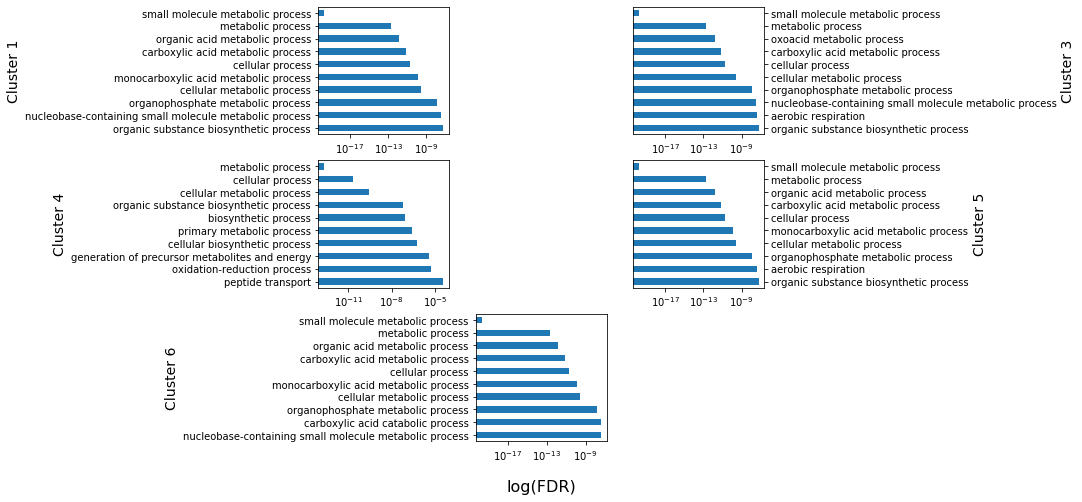

In [38]:
name = 'FL'
node_table = pd.read_csv('./Data/NodeTables/node_table_{}.tsv'.format(name), sep='\t')
bingo_table = pd.read_csv('./Data/GO_Enrichment/tables/{}_GO_P.csv'.format(name), sep='\t')

fig = plt.figure(figsize=(8, 8))

ax_cl1 = fig.add_subplot(3, 3, 1)
ax_cl2 = fig.add_subplot(3, 3, 3)
ax_cl3 = fig.add_subplot(3, 3, 4)
ax_cl4 = fig.add_subplot(3, 3, 6)
ax_cl5 = fig.add_subplot(3, 3, 8)

axClustTermSigBar(bingo_table, node_table, [ax_cl1, ax_cl2, ax_cl3, ax_cl4, ax_cl5])

ax_cl2.yaxis.set_label_position("right")
ax_cl2.yaxis.tick_right()
ax_cl4.yaxis.set_label_position("right")
ax_cl4.yaxis.tick_right()

ax_cl5.set_xlabel('log(FDR)', size= 16)
ax_cl5.get_xaxis().set_label_coords(0.5, -0.3)

# plt.savefig('./Plots/{}_ClusTermSig.png'.format(name), dpi=200, bbox_inches='tight')
plt.show()

LF

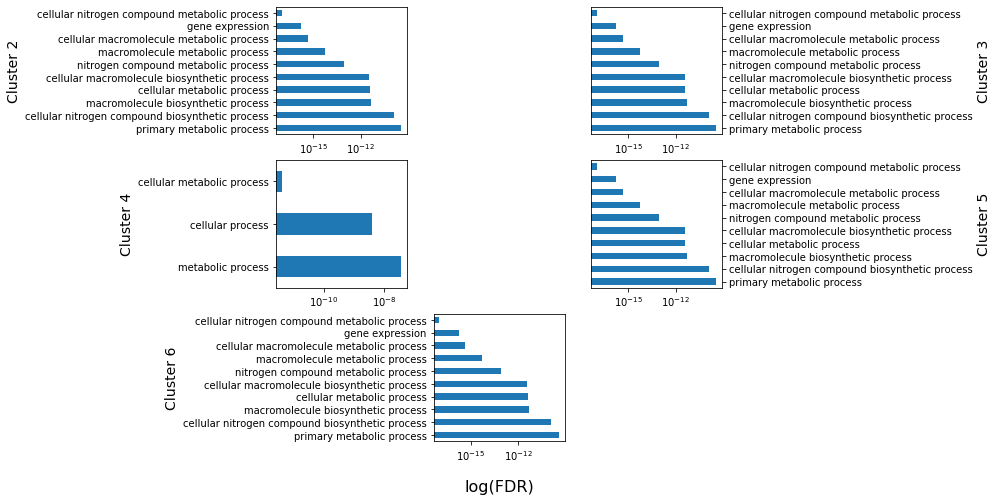

In [39]:
name = 'LF'
node_table = pd.read_csv('./Data/NodeTables/node_table_{}.tsv'.format(name), sep='\t')
bingo_table = pd.read_csv('./Data/GO_Enrichment/tables/{}_GO_P.csv'.format(name), sep='\t')

fig = plt.figure(figsize=(8, 8))

ax_cl1 = fig.add_subplot(3, 3, 1)
ax_cl2 = fig.add_subplot(3, 3, 3)
ax_cl3 = fig.add_subplot(3, 3, 4)
ax_cl4 = fig.add_subplot(3, 3, 6)
ax_cl5 = fig.add_subplot(3, 3, 8)

axClustTermSigBar(bingo_table, node_table, [ax_cl1, ax_cl2, ax_cl3, ax_cl4, ax_cl5])

ax_cl2.yaxis.set_label_position("right")
ax_cl2.yaxis.tick_right()
ax_cl4.yaxis.set_label_position("right")
ax_cl4.yaxis.tick_right()

ax_cl5.set_xlabel('log(FDR)', size= 16)
ax_cl5.get_xaxis().set_label_coords(0.5, -0.3)

plt.savefig('./Plots/{}_ClusTermSig.png'.format(name), dpi=200, bbox_inches='tight')
plt.show()

SQ

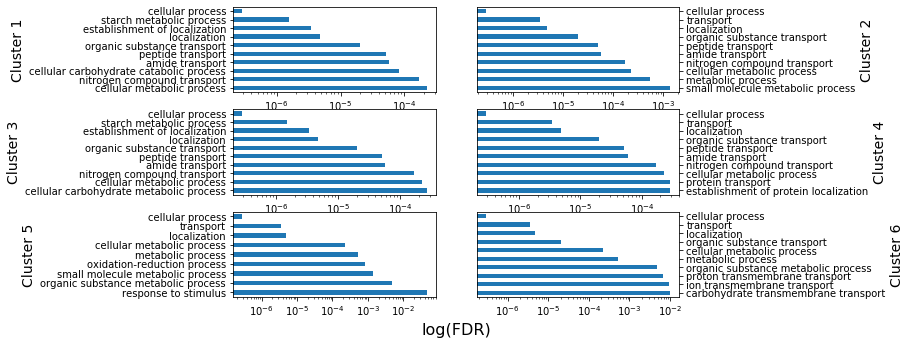

In [40]:
name = 'SQ'
node_table = pd.read_csv('./Data/NodeTables/node_table_{}.tsv'.format(name), sep='\t')
bingo_table = pd.read_csv('./Data/GO_Enrichment/tables/{}_GO_P.csv'.format(name), sep='\t')

fig = plt.figure(figsize=(8, 11))

ax_cl1 = fig.add_subplot(6, 2, 1)
ax_cl2 = fig.add_subplot(6, 2, 2)
ax_cl3 = fig.add_subplot(6, 2, 3)
ax_cl4 = fig.add_subplot(6, 2, 4)
ax_cl5 = fig.add_subplot(6, 2, 5)
ax_cl6 = fig.add_subplot(6, 2, 6)

axClustTermSigBar(bingo_table, node_table, [ax_cl1, ax_cl2, ax_cl3, ax_cl4, ax_cl5, ax_cl6])

ax_cl2.yaxis.set_label_position("right")
ax_cl2.yaxis.tick_right()
ax_cl4.yaxis.set_label_position("right")
ax_cl4.yaxis.tick_right()
ax_cl6.yaxis.set_label_position("right")
ax_cl6.yaxis.tick_right()

ax_cl6.set_xlabel('log(FDR)', size= 16)
ax_cl6.get_xaxis().set_label_coords(-0.1, -0.3)

plt.savefig('./Plots/{}_ClusTermSig.png'.format(name), dpi=200, bbox_inches='tight')
plt.show()

## Bar Plot of Data Entries After Filtering Steps

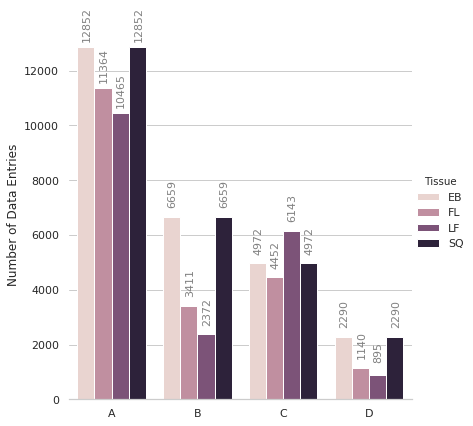

In [3]:
data = pd.read_csv('./Data/dataentries.tsv', sep= '\t')

sb.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sb.catplot(x="FILTER", y="VALUE", hue="TISSUE", data=data,
                height=6, kind="bar", palette=sb.cubehelix_palette(4))

ax=g.ax
#annotate axis = seaborn axis
for p in ax.patches:
    height = "%.2f" % p.get_height()
    ax.annotate(height.split('.')[0], (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', xytext=(1, 23),
         textcoords='offset points', rotation=90)

g.despine(left=True)
g.set_ylabels("Number of Data Entries")
g.set_xlabels("")
g._legend.set_title('Tissue')
g.savefig('./Plots/barfilter.png', dpi= 200)
plt.show()

## Bar Plot of Number of Terms / Sig. Enriched Terms in DAG

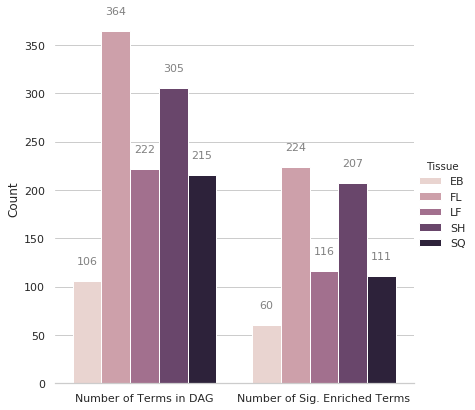

In [15]:
data = pd.read_csv('./Data/DAGCountTable.tsv', sep= '\t')

sb.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sb.catplot(x="CATEGORY", y="VALUE", hue="TISSUE", data=data,
                height=6, kind="bar", palette=sb.cubehelix_palette(5))
ax=g.ax
#annotate axis = seaborn axis
for p in ax.patches:
    height = "%.2f" % p.get_height()
    ax.annotate(height.split('.')[0], (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
         textcoords='offset points')

g.despine(left=True)
g.set_ylabels("Count")
g.set_xlabels("")
g._legend.set_title('Tissue')
g.savefig('./Plots/bardag.png', dpi= 200)
plt.show()

## Bar Plot of Number of Nodes in (Un)Specific Networks

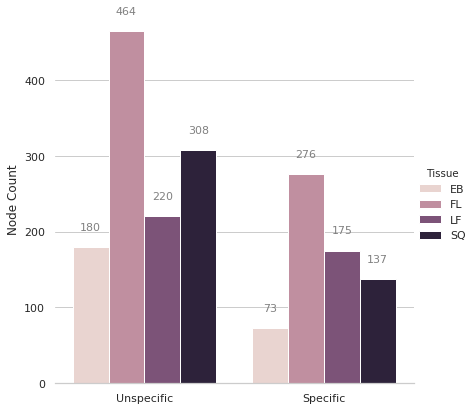

In [4]:
data = pd.read_csv('./Data/NetSizeTable.tsv', sep= '\t')

sb.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sb.catplot(x="TYPE", y="VALUE", hue="TISSUE", data=data,
                height=6, kind="bar", palette=sb.cubehelix_palette(4))

ax=g.ax
#annotate axis = seaborn axis
for p in ax.patches:
    height = "%.2f" % p.get_height()
    ax.annotate(height.split('.')[0], (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
         textcoords='offset points')

g.despine(left=True)
g.set_ylabels("Node Count")
g.set_xlabels("")
g._legend.set_title('Tissue')
g.savefig('./Plots/barnets.png', dpi= 200)
plt.show()

## Bar Plot showing Raw Data Sizes

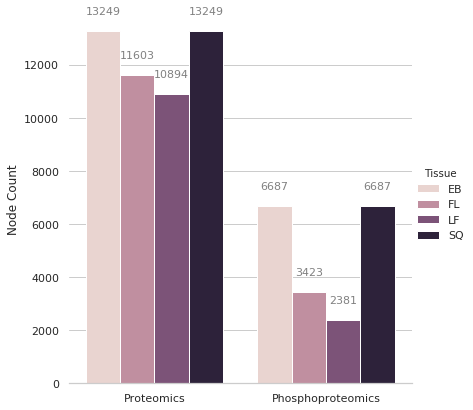

In [7]:
data = pd.read_csv('./Data/RawDataSizes.tsv', sep= '\t')

sb.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sb.catplot(x="CATEGORY", y="VALUE", hue="TISSUE", data=data,
                height=6, kind="bar", palette=sb.cubehelix_palette(4))

ax=g.ax
#annotate axis = seaborn axis
for p in ax.patches:
    height = "%.2f" % p.get_height()
    ax.annotate(height.split('.')[0], (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
         textcoords='offset points')

g.despine(left=True)
g.set_ylabels("Node Count")
g.set_xlabels("")
g._legend.set_title('Tissue')
g.savefig('./Plots/barrawsize.png', dpi= 300)
plt.show()

## Vertical Bar Plot Showing Number of Time Points

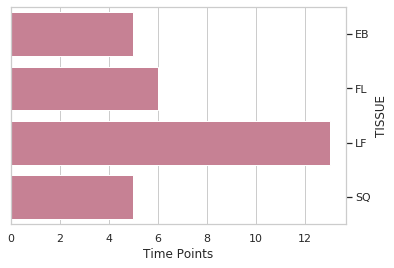

In [34]:
data = pd.DataFrame.from_dict({'TISSUE': ['EB', 'FL', 'LF', 'SQ'], 'Time Points': [5, 6, 13, 5]})
sb.set(style="whitegrid")
g = sb.barplot(x="Time Points", y="TISSUE", data=data, color=sb.xkcd_rgb["muted pink"])
g.yaxis.tick_right()
g.yaxis.set_label_position("right")

plt.savefig('./Plots/timepoints.png', dpi= 300)
plt.show()

# Preperation of PPI

In [4]:
## load raw ppi data ##
ppi_file = './Data/Raw/3702.protein.links.v11.0.txt'
ppi_table = pd.read_csv(ppi_file, sep=' ', dtype=str)

In [5]:
c = 900 # set cut off fpr string score

tmp_ppi_table = ppi_table.copy()
tmp_ppi_table['combined_score'] = pd.to_numeric(tmp_ppi_table['combined_score']) # get combined score

print('calculating %s score cutoff' % c) # filter for set cut-off
tmp_ppi_table = tmp_ppi_table.drop(tmp_ppi_table[tmp_ppi_table["combined_score"] < c].index)
tmp_ppi_table = tmp_ppi_table.dropna()
tmp_ppi_table.reset_index(inplace=True, drop=True)

del tmp_ppi_table["combined_score"] # delete the score column after selection

tmp_ppi_table["protein1"] = tmp_ppi_table["protein1"].map(lambda a : a.replace('3702.', '')) # remove not needed id prefix
tmp_ppi_table["protein2"] = tmp_ppi_table["protein2"].map(lambda a : a.replace('3702.', ''))
tmp_ppi_table = tmp_ppi_table.rename(columns = {'protein1' : 'SOURCE', 'protein2' : 'TARGET'})
print('building ppi set')
ppi_set = set()
ppi_set.update(tmp_ppi_table['SOURCE'].values)
ppi_set.update(tmp_ppi_table['TARGET'].values)

calculating 900 score cutoff
building ppi set


In [124]:
print('exporting ppi')
ppi_sif = tmp_ppi_table.copy()
ppi_sif["INTERACTION"] = "pp"
ppi_sif = ppi_sif[["protein1", "INTERACTION", "protein2"]]

ppi_sif.to_csv('./Data/StringAtPPI%s.sif' % c, sep="\t", index=False, header=False)

exporting ppi


# Pipeline

In [6]:
def pipeline(data_type='', string_cut=900, sample=False, square_data=False, quantile_cut=-1, rm_outliers=False, normalize=False, combine= True, as_env_var=True):
    """
    The function to control all pipelines. Loads in raw data when needed.
    data_type [prot/phos]    : Choose which pipeline to run.
    string_cut [0-1000]      : Set STRING-score cut-off (zero for no cut-off).
    filter_var [True/False]  : For phos pipeline only. Select if result should be filtered for highest variance.
    square_data [True/False] : Select if data should be squared during preprocessing.
    quantile_cut [0-100]     : Set upper limit for quantile cut-off (zero for no cut-off).
    rm_outliers [True/False] : Select if outliers should be remooved.
    normalize [True/False]   : Select if data should be z-score normalized.
    as_env_var [True/False]  : Select if result of pipeline is only for us in environment or if data should also be exported.
    """
    
    
    if data_type == 'prot':
        return prot_pipeline(c=string_cut, quad=square_data, norm=normalize, comb=combine, env=as_env_var)
    elif data_type == 'phos':
        return phos_pipeline(c=string_cut, square=square_data, sample=sample, norm=normalize,comb=combine, env=as_env_var)
    else:
        print('No or wrong data_type was given. Choose either \'prot\' or \'phos\'. Your selection was \'{}\''.format(data_type))

## Proteomics Pipeline

In [7]:
def prot_pipeline(c, quad, norm, comb, env):
    active_pipeline = 'prot'
    ## load raw expression data ## 
    SQEB_table = import_df(path='./Data/Raw/proteinGroups_EB.tsv')
    FL_table = import_df(path='./Data/Raw/proteinGroups_FL.tsv')
    LF_table = import_df(path='./Data/Raw/proteinGroups_LF.tsv')

    # remove unwanted rows
    SQEB_table = filter_table(SQEB_table, 'prot')
    FL_table = filter_table(FL_table, 'prot')
    LF_table = filter_table(LF_table, 'prot')
    
    print('copying IDs')
    SQEB = SQEB_table[['Majority protein IDs']].copy()
    SQEB.columns = ['Protein']

    FL = FL_table[['Majority protein IDs']].copy()
    FL.columns = ['Protein']

    LF = LF_table[['Majority protein IDs']].copy()
    LF.columns = ['Protein']

    print('removing non majority protein ids.')
    transform_id(df=SQEB)
    transform_id(df=FL)
    transform_id(df=LF)

    print('adding expression values to tables containing ids')
    ## FL
    for i in range(0, 6):
        FL['FL time point %s' % i] = FL_table['Reporter intensity %s' % i].astype(float)

    ## SQ
    SQ = SQEB[['Protein']]
    for i in range(0, 5):
        SQ['SQEB time point %s' % i] = SQEB_table['Reporter intensity %s' % i].astype(float)

    # EB
    EB = SQEB[['Protein']]
    for i in range(5, 10):
        EB['SQEB time point %s' % i] = SQEB_table['Reporter intensity %s' % i].astype(float)

    ## LF
    LF_corr = import_df(path='./Data/Processed/PostComBat_NonLog.tsv')
    
    if comb:
        LF_corr = comb_lf(df=LF_corr, limited=False, data_type='prot')

    for i in range(len(LF_corr.columns)):
        LF['LF time point %s' % i] = LF_corr.iloc[:,i].astype(float)
    
    print('Number of proteins left after MaxQuant filtering:\nEB: {}\nFL: {}\nLF: {}\nSQ: {}'.format(len(EB), len(FL), len(LF), len(SQ)))
    
    if c >= 0:
        print('removing proteins not present in ppi')
        SQ = map_to_ppi(SQ, ppi_set)
        SQ = SQ.reset_index(drop=True)

        EB = map_to_ppi(EB, ppi_set)
        EB = EB.reset_index(drop=True)

        FL = map_to_ppi(FL, ppi_set)
        FL = FL.reset_index(drop=True)

        LF = map_to_ppi(LF, ppi_set)
        LF = LF.reset_index(drop=True)
        
    FL_num_cols = get_num_cols(FL)
    SQ_num_cols = get_num_cols(SQ)
    EB_num_cols = get_num_cols(EB)
    LF_num_cols = get_num_cols(LF)
        
    if quad:
        print('spreading data')
        EB[EB_num_cols] = EB[EB_num_cols] ** 2
        FL[FL_num_cols] = FL[FL_num_cols] ** 2
        LF[LF_num_cols] = LF[LF_num_cols] ** 2
        SQ[SQ_num_cols] = SQ[SQ_num_cols] ** 2
        
    if norm:
        print('transforming to log2 fold change')
        
        EB[EB_num_cols] = EB[EB_num_cols].apply(lambda x : logfc_series(x, True), axis=1)
        FL[FL_num_cols] = FL[FL_num_cols].apply(lambda x : logfc_series(x, True), axis=1)
        LF[LF_num_cols] = LF[LF_num_cols].apply(lambda x : logfc_series(x, True), axis=1)
        SQ[SQ_num_cols] = SQ[SQ_num_cols].apply(lambda x : logfc_series(x, True), axis=1)
         

    if not env:
        directory = './Data/Processed/'
        prefix = 'prot'

        print('exporting\n------------------------')

        export(df=SQ, path= '{}/prot_SQ.tsv'.format(directory), h=False)
        export(df=EB, path= '{}/prot_EB.tsv'.format(directory), h=False)
        export(df=FL, path= '{}/prot_FL.tsv'.format(directory), h=False)
        export(df=LF, path= '{}/prot_LF.tsv'.format(directory), h=False)

    print('\nfinished')
    
    return EB, FL, LF, SQ

### Execute

In [8]:
protEB, protFL, protLF, protSQ = pipeline(data_type='prot', 
                                          square_data=False, 
                                          normalize = False, 
                                          as_env_var=True)
active_pipeline = 'prot'

Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
copying IDs
removing non majority protein ids.
adding expression values to tables containing ids
Number of proteins left after MaxQuant filtering:
EB: 12852
FL: 11364
LF: 10465
SQ: 12852
removing proteins not present in ppi
Removing all proteins which are not present in the ppi network.
7880 proteins not found in ppi.
4972 proteins left.
Removing all proteins which are not present in the ppi network.
7880 proteins not found in ppi.
4972 proteins left.
Removing all proteins which are not present in the ppi network.
6912 proteins not found in ppi.
4452 proteins left.
Removing all proteins which are not present 

## Phosphoproteomics Pipeline

In [9]:
def phos_pipeline(c, square, sample, norm, comb, env):
    active_pipeline = 'phos'
    SQEB_table = import_df(path='./Data/Raw/Phospho (STY)Sites_EB.tsv')
    FL_table = import_df(path='./Data/Raw/Phospho (STY)Sites_FL.tsv')
    LF_table = import_df(path='./Data/Raw/Phospho (STY)Sites_LF.tsv')

    SQEB_table = filter_table(SQEB_table, 'phos')
    FL_table = filter_table(FL_table, 'phos')
    LF_table = filter_table(LF_table, 'phos')
    
    print('adding expression values to tables containing ids')
    
    FL = FL_table[['Protein']].copy()
    LF = LF_table[['Protein']].copy()
    SQEB = SQEB_table[['Protein']].copy()
    
     # EB
    EB = SQEB[['Protein']]
    for i in range(5, 10):
        EB['SQEB time point %s' % i] = SQEB_table['Reporter intensity %s' % i].astype(float)
    
    ## FL
    for i in range(0, 6):
        FL['FL time point %s' % i] = FL_table['Reporter intensity %s' % i].astype(float)
        
    ## LF
    LF_corr = import_df(path='./Data/Processed/PostComBat_P_NonLog.tsv')
    LF_corr = LF_corr.astype(float)
    
    if comb:
        LF_corr = comb_lf(df=LF_corr, limited=False, data_type='phos')

    for i in range(len(LF_corr.columns)):
        LF['LF time point %s' % i] = LF_corr.iloc[:,i].astype(float)

    ## SQ
    SQ = SQEB[['Protein']]
    for i in range(0, 5):
        SQ['SQEB time point %s' % i] = SQEB_table['Reporter intensity %s' % i].astype(float)
    
    print('Number of peptides left after MaxQuant filtering:\nEB: {}\nFL: {}\nLF: {}\nSQ: {}'.format(len(EB), len(FL), len(LF), len(SQ)))
    if c > 0:
        print('removing proteins not present in ppi')
        print('EB')
        EB = map_to_ppi(EB, ppi_set)
        EB = EB.reset_index(drop=True)
    
        print('FL')
        FL = map_to_ppi(FL, ppi_set)
        FL = FL.reset_index(drop=True)

        print('LF')
        LF = map_to_ppi(LF, ppi_set)
        LF = LF.reset_index(drop=True)
        
        print('SQ:')
        SQ = map_to_ppi(SQ, ppi_set)
        SQ = SQ.reset_index(drop=True)

    EB_num_cols = get_num_cols(EB)
    FL_num_cols = get_num_cols(FL)
    LF_num_cols = get_num_cols(LF)
    SQ_num_cols = get_num_cols(SQ)
    
    
    if square:
        print('spreading data')
        EB[EB_num_cols] = EB[EB_num_cols] ** 2
        FL[FL_num_cols] = FL[FL_num_cols] ** 2
        LF[LF_num_cols] = LF[LF_num_cols] ** 2
        SQ[SQ_num_cols] = SQ[SQ_num_cols] ** 2
    
    if norm:
        print('normalizing data')
        EB[EB_num_cols] = pd.DataFrame(StandardScaler().fit_transform(EB[EB_num_cols]))
        FL[FL_num_cols] = pd.DataFrame(StandardScaler().fit_transform(FL[FL_num_cols]))
        LF[LF_num_cols] = pd.DataFrame(StandardScaler().fit_transform(LF[LF_num_cols]))
        SQ[SQ_num_cols] = pd.DataFrame(StandardScaler().fit_transform(SQ[SQ_num_cols]))
               
    if sample:
        build_sample(EB, False)
        build_sample(FL, False)
        build_sample(LF, False)
        build_sample(SQ, False)
            

    if not env:
        directory = './Data/Processed/'
        print('exporting\n------------------------')

        export(df=SQ, path= '{}/phos_SQ.tsv'.format(directory), h=False)
        export(df=EB, path= '{}/phos_EB.tsv'.format(directory), h=False)
        export(df=FL, path= '{}/phos_FL.tsv'.format(directory), h=False)
        export(df=LF, path= '{}/phos_LF.tsv'.format(directory), h=False)

    print('\nfinished')
    
    return EB, FL, LF, SQ

### Execute

In [10]:
phosEB, phosFL, phosLF, phosSQ = pipeline(data_type='phos', 
                                          square_data=False, 
                                          sample=False, 
                                          normalize = False, 
                                          as_env_var=True)
active_pipeline = 'phos'

Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
adding expression values to tables containing ids
Number of peptides left after MaxQuant filtering:
EB: 6659
FL: 3411
LF: 2372
SQ: 6659
removing proteins not present in ppi
EB
Removing all proteins which are not present in the ppi network.
4369 proteins not found in ppi.
2290 proteins left.
FL
Removing all proteins which are not present in the ppi network.
2271 proteins not found in ppi.
1140 proteins left.
LF
Removing all proteins which are not present in the ppi network.
1477 proteins not found in ppi.
895 proteins left.
SQ:
Removing all proteins which are not present in the ppi network.
4369 proteins not f

# Build LFC Tables

In [12]:
# calculate the log2 fold change for all data frames in the dict
logfc_prot_dict = {}
for name in prot_rawexpr_dict:
    pids = prot_rawexpr_dict[name]['Protein'].copy()
    logfc_prot_dict[name] = pd.concat([logfc_series(pd.Series(row[1:])) for index, row in prot_rawexpr_dict.get(name).iterrows()], axis=1).T
    logfc_prot_dict.get(name)['PID'] = pids

In [14]:
directory = "./Data/Processed/"
for name in logfc_prot_dict:
    logfc_prot_dict.get(name).to_csv("{}logfc_prot_{}.tsv".format(directory, name), index=False, sep="\t")

# KPM Encoding Using Log2-Foldchange

In [12]:
def calc_log2_fc_indicator(df, sig):
    """
    Create a KPM indicator table from given expression values and significance threshold
    """
    df.iloc[:,1:] = df.iloc[:,1:] + 1
    # calculate foldchange
    foldchangeDF = pd.DataFrame()

    for index, row in df.iterrows():
        row_fc = []

        for i in range(1, len(row)-1):
#             fc = row[i+1]/(row[i]-1)
            fc = row[i+1]/row[i]
            row_fc.append(np.abs(fc))

        foldchangeDF = foldchangeDF.append(pd.Series(row_fc, dtype=float), ignore_index=True)
        
    # take log2 of foldchange
    log2fcDF = foldchangeDF.applymap(lambda x : np.log2(x))
    log2fcDF[len(log2fcDF.columns)] = df['Protein']
    log2fcDF.dropna(inplace=True)

    # build indocator based on cut-off
    log2fcDF.iloc[:,:-1] = log2fcDF.iloc[:,:-1] > sig
    
    
    column_order = [log2fcDF.columns[-1]]
    column_order.extend(log2fcDF.columns[:-1].tolist()) 
    
    log2fcDF = log2fcDF[column_order] 
    log2fcDF.columns = [i for i in range(len(log2fcDF.columns))]
    
#     set_trace()
    
    duplicate_rows = log2fcDF[log2fcDF.duplicated(subset=[log2fcDF.columns[0]], keep = False)]
    duplicate_rows = duplicate_rows * 1
    
    if len(duplicate_rows) > 0:
        
        merged_df = pd.DataFrame(columns=log2fcDF.columns)
        seen_ids = set()
        for index, row in duplicate_rows.iterrows():
            row_id = row[log2fcDF.columns[0]]
            if row_id not in seen_ids:

                seen_ids.add(row_id)
                
                sum_series = duplicate_rows.loc[duplicate_rows[duplicate_rows.columns[0]] == row_id].sum(numeric_only=True)
                sum_series = sum_series.map(lambda x : 1 if x > 0 else 0)
                
                # combine id and indicators
                tmp_series = pd.Series([row_id])
                tmp_series = tmp_series.append(sum_series, ignore_index=True)

                #merge to into a new data frame
                merged_df = merged_df.append(tmp_series, ignore_index=True)
        
        
        log2fcDF = log2fcDF.drop_duplicates(keep=False, subset=[log2fcDF.columns[0]])
        log2fcDF = log2fcDF.append(merged_df, ignore_index=True)
    
    
    return log2fcDF * 1

In [14]:
indicatorProtEB = calc_log2_fc_indicator(protEB, 0.2)
indicatorProtFL = calc_log2_fc_indicator(protFL, 0.2)
indicatorProtLF = calc_log2_fc_indicator(protLF, 0.2)
indicatorProtSQ = calc_log2_fc_indicator(protSQ, 0.2)

In [13]:
indicatorPhosEB = calc_log2_fc_indicator(phosEB, 0.2)
indicatorPhosFL = calc_log2_fc_indicator(phosFL, 0.2)
indicatorPhosLF = calc_log2_fc_indicator(phosLF, 0.2)
indicatorPhosSQ = calc_log2_fc_indicator(phosSQ, 0.2)

In [23]:
directory = './Data/Processed/IndicatorMatrices/'

indicatorProtEB.to_csv('{}protEB.txt'.format(directory), sep='\t', index=False, header=False)
indicatorProtFL.to_csv('{}protFL.txt'.format(directory), sep='\t', index=False, header=False)
indicatorProtLF.to_csv('{}protLF.txt'.format(directory), sep='\t', index=False, header=False)
indicatorProtSQ.to_csv('{}protSQ.txt'.format(directory), sep='\t', index=False, header=False)

indicatorPhosEB.to_csv('{}phosEB.txt'.format(directory), sep='\t', index=False, header=False)
indicatorPhosFL.to_csv('{}phosFL.txt'.format(directory), sep='\t', index=False, header=False)
indicatorPhosLF.to_csv('{}phosLF.txt'.format(directory), sep='\t', index=False, header=False)
indicatorPhosSQ.to_csv('{}phosSQ.txt'.format(directory), sep='\t', index=False, header=False)

# Node Table Construction
Gather all data into one table for inport to Cytoscape.

### Functions and Setup

In [15]:
# Launch expression pipeline on protein centric data.
protEB, protFL, protLF, protSQ = pipeline(data_type='prot', 
                                          square_data=False, 
                                          normalize = False, 
                                          as_env_var=True)

# Launch expression pipeline on site centric data, which was enriched with phsophorus.
phosEB, phosFL, phosLF, phosSQ = pipeline(data_type='phos', 
                                          square_data=False, 
                                          sample=False, 
                                          normalize = False, 
                                          as_env_var=True)

# Put filtered data into dictionaries for ease of use
prot_rawexpr_dict = {'EB':protEB, 'FL':protFL, 'LF':protLF, 'SQ':protSQ}
phos_rawexpr_dict = {'EB':phosEB, 'FL':phosFL, 'LF':phosLF, 'SQ':phosSQ}

def build_cluster_map(file):
    cluster_dict = dict()
    
    for line in file:
        line = line.strip()
        line = line.split('\t')
        
        cluster_dict[line[1]] = int(line[0].split(' ')[1])
    
    return cluster_dict

def getGoInformation(unique_ids):
    # id mapping
    url = 'https://www.uniprot.org/uploadlists/'
    query = ['3702.{}'.format(e) for e in unique_ids]
    
    params = {
    'from': 'STRING_ID',
    'to': 'ACC',
    'format': 'tab',
    'query': ', '.join(query)
    }

    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    print('accessing uniprot for id mapping')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
        response = f.read()
    response = response.decode('utf-8')

    response = response.split('\n')
    
    id_frame = pd.DataFrame(columns=["ID", "UNIPROTID"])
    id_frame = id_frame.append([{'ID' : x.split('\t')[0].lstrip('3702.'),'UNIPROTID' : x.split('\t')[1]} for x in response[1:-1]], ignore_index=True)
    
    # information retrieval
    url = 'https://www.uniprot.org/uploadlists/'

    params = {
    'from': 'ACC+ID',
    'to': 'ACC',
    'format': 'xml',
    'query': ' '.join(id_frame['UNIPROTID'])
    }

    response = ''
    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    print('Starting batch entry retrieval.')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
        response = f.read().decode('utf-8')
    
    #parsing
    go_frame = pd.DataFrame(columns=['UNIPROTID', 'NAME'])
    
    print('Creating Soup...')
    FullSoup = BeautifulSoup(response, 'xml')
    print('Soup Finished. Starting Parsing of Entries...')
    
    accession = ''
    for e in FullSoup.find_all('entry'):
        go_term_dict = {}
        accession = e.find('accession').text
        fullName = e.protein.fullName.text
        name = fullName if len(fullName) > 0 else accession

        go_frame = go_frame.append({'UNIPROTID': accession, 'NAME': name}, ignore_index= True)
    return id_frame.merge(go_frame, how='left', on='UNIPROTID')


Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
Remove proteins that match the unwanted features: identification by site, match on a reverse sequence and potential contaminant
copying IDs
removing non majority protein ids.
adding expression values to tables containing ids
Number of proteins left after MaxQuant filtering:
EB: 12852
FL: 11364
LF: 10465
SQ: 12852
removing proteins not present in ppi
Removing all proteins which are not present in the ppi network.
7880 proteins not found in ppi.
4972 proteins left.
Removing all proteins which are not present in the ppi network.
7880 proteins not found in ppi.
4972 proteins left.
Removing all proteins which are not present in the ppi network.
6912 proteins not found in ppi.
4452 proteins left.
Removing all proteins which are not present 

In [16]:
def build_node_table(pathway, prot_expr_frame, phos_expr_frame, prot_clusters, name= None):
    """
    Function which assembles a node table containing different information of the data, based on a pathway table.
    pathway : Pandas DataFrame with SOURCE and TARGET column of the network for which the node table should be build.
    prot_expr_frame : Pandas DataFrame containing proteimics expression values.
    phos_expr_frame : Pandas DataFrame containing phosphoproteomics values.
    prot_clustres : Dictionary with the cluster number as key and araport ids which are part of that cluster as value of proteomics data.
    phos_clustres : Dictionary with the cluster number as key and araport ids which are part of that cluster as value of phosphoproteomics data.
    """
    
    # build new data frame which will be used as skeleton to which all wanted information is added
    prot_lfc_name = ['LFC_{}-{}'.format(i, i+1) for i in range(len(prot_expr_frame.columns)-2)]
    columns = ['ID','TISSUE', 'MIN', 'MAX', 'VAR', 'ISPHOS', 'CLUSTER']
    columns.extend(prot_lfc_name)
    
    node_table = pd.DataFrame(columns=columns)
    
    unique_ids = set()
    unique_ids.update(pathway['SOURCE'].unique())
    unique_ids.update(pathway['TARGET'].unique())
    
    for uid in unique_ids:
        clear_output(wait=True)
        print('Working on {}'.format(uid))
        
        entry = pd.Series()
        entry['ID'] = uid
        
        # add cluster information; if id not in cluster set -1
        prot_cluster_num = -1 if prot_clusters.get(entry['ID']) == None else prot_clusters.get(entry['ID']) 
        
        # look up if the protein has phosphorelation sites        
        entry['ISPHOS'] = 1 if phos_expr_frame['Protein'].str.contains(uid).any() else 0 # TODO : lookup in expression and not through clusters 
        entry['CLUSTER'] = prot_cluster_num
        
        # add proteomics expression
        tmp_data = prot_expr_frame.loc[prot_expr_frame['Protein'] == entry['ID']].iloc[:,1:]
        tmp_data = tmp_data.values[0] if not tmp_data.empty else None

        expr_series = pd.Series(tmp_data)
        var = 0
        min_lfc = 0
        max_lfc = 0
        
        # use measured protein expression if available
        if len(expr_series) > 0:
            lfc_series = logfc_series(expr_series)
            entry = entry.append(lfc_series)
            min_lfc = lfc_series.min()
            max_lfc = lfc_series.max()
            var = lfc_series.var()
        else: 
            print('No proteomics values found for {}.'.format(uid))
            continue
        
        entry['MIN'] = min_lfc
        entry['MAX'] = max_lfc
        entry['VAR'] = var
        entry['LFCDIFF'] = max_lfc - min_lfc
        
        node_table = node_table.append(entry, ignore_index=True, sort = False)
    
    if name != None:
        node_table['SOURCETISSUE'] = name
    go_frame = getGoInformation(unique_ids)
    return node_table.merge(go_frame, how='inner', on='ID')

### Build Cluster List

In [17]:
# load in clusters an build dictionaries
directory = './Data/Clusters/Ticone/Uncut/LOG2FC/'
tissues = ['EB', 'FL', 'LF', 'SQ']

prot_clust_dict = {}
phos_clust_dict = {}

for tf in os.listdir(directory):
    file = open('{}{}'.format(directory, tf),'r')
    for t in tissues:
        if t in file.name:
            print('Starting work on file : {}'.format(file.name))
            if 'Phos' in tf or 'phos' in tf:
                phos_clust_dict[t] = build_cluster_map(file)
            else:
                prot_clust_dict[t] = build_cluster_map(file)

Starting work on file : /home/thibault/Documents/bachelorarbeit/Data/Clusters/Ticone/Uncut/LOG2FC/lfc_EB.tsv
Starting work on file : /home/thibault/Documents/bachelorarbeit/Data/Clusters/Ticone/Uncut/LOG2FC/lfc_SQ.tsv
Starting work on file : /home/thibault/Documents/bachelorarbeit/Data/Clusters/Ticone/Uncut/LOG2FC/lfc_LF.tsv
Starting work on file : /home/thibault/Documents/bachelorarbeit/Data/Clusters/Ticone/Uncut/LOG2FC/lfc_FL.tsv


### Build Node Table for Tissue Specific Networks

In [18]:
node_table_dict = {}
for name in specific_interactions:                                                 
    print('building table for ' + name)
    node_table_dict[name] = build_node_table(specific_interactions.get(name),
                                            prot_rawexpr_dict.get(name),
                                            phos_rawexpr_dict.get(name),
                                            prot_clust_dict.get(name))
    node_table_dict.get(name)["SOURCETISSUE"] = name
    node_table_dict.get(name)["TISSUE"] = name

Working on AT3G07680.1
accessing uniprot for id mapping
Starting batch entry retrieval.
Creating Soup...
Soup Finished. Starting Parsing of Entries...


Export Specific

In [20]:
for name in node_table_dict:
    node_table_dict.get(name).to_csv('./Data/NodeTables/node_table_{}.tsv'.format(name),sep='\t', index=False)   

### Build Node Table for Network of Shared Proteins

In [21]:
shared_node_table = pd.DataFrame(columns=['ID' ,'GO_C' ,'GO_P' ,'LFCDIFF', 'CLUSTER', 'ISPHOS', 'LFC_0-1',
       'LFC_1-2', 'LFC_2-3', 'LFC_3-4', 'LFC_4-5', 'LFC_5-6', 'LFC_6-7', 'LFC_7-8', 'LFC_8-9', 'LFC_9-10',
       'LFC_10-11', 'LFC_11-12', 'MAX', 'MIN', 'NAME', 'UNIPROTID', 'VAR', 'TISSUE'])
tissues = ['EB', 'FL', 'LF', 'SQ']
for name in tissues:
    shared_node_table = shared_node_table.append(build_node_table(shared_interactions,
                                                     prot_rawexpr_dict.get(name),
                                                     phos_rawexpr_dict.get(name),
                                                     prot_clust_dict.get(name), name), sort = False)
shared_node_table["TISSUE"] = "SH"

Working on AT2G24590.1
accessing uniprot for id mapping
Starting batch entry retrieval.
Creating Soup...
Soup Finished. Starting Parsing of Entries...


Export Shared

In [23]:
shared_node_table.to_csv('./Data/NodeTables/node_table_{}.tsv'.format("SH"),sep='\t', index=False)

### Build Node Table for Total Network

In [51]:
node_table_TO = node_table_dict.get("EB").append(node_table_dict.get("FL"), ignore_index=True, sort=False)
node_table_TO = node_table_TO.append(node_table_dict.get("LF"), ignore_index=True, sort=False)
node_table_TO = node_table_TO.append(node_table_dict.get("SQ"), ignore_index=True, sort=False)
node_table_TO = node_table_TO.append(shared_node_table, ignore_index=True, sort=False)
node_table_TO = node_table_TO[['ID' ,'UNIPROTID' ,'CLUSTER', 'GO_C', 'GO_P', 'ISPHOS', 'LFCDIFF', 'MAX', 'MIN', 'NAME',  'VAR', 'TISSUE', 'SOURCETISSUE','LFC_0-1',
       'LFC_1-2', 'LFC_2-3', 'LFC_3-4', 'LFC_4-5', 'LFC_5-6', 'LFC_6-7', 'LFC_7-8', 'LFC_8-9', 'LFC_9-10',
       'LFC_10-11', 'LFC_11-12']]

Export Total Node Table

In [55]:
node_table_TO.to_csv('./Data/NodeTables/node_table_{}.tsv'.format("TO"),sep='\t', index=False)

# Tissue Specific Pathways

In [6]:
def rebuild_network(pid_set, ppi_table):
    interactions = pd.DataFrame(columns=('SOURCE', 'TARGET'))
    
    for pid in pid_set:
        
        # Check in global ppi table for interactions because KPM web output may not contain all knwon interactions
        active_interactions = ppi_table.loc[ppi_table['SOURCE'] == pid]
        tmp_interactions = active_interactions[[x in pid_set for x in active_interactions['TARGET']]]
        if tmp_interactions.empty:
            interactions = interactions.append({'SOURCE': pid, 'TARGET': 'NaN'}, ignore_index=True)
        else:
            interactions = interactions.append(tmp_interactions)
        
    return interactions

Import KPM Networks

In [7]:
directory = './Data/Clusters/KPM/Used/'
pathway_frames = {}
pathway_sets = {}
for file in os.listdir(directory):    
    file_path = '{}{}'.format(directory, file)
    name = file.split('_')[0]
    # load tables for interaction lookup
    pathway_frames[name] = pd.read_csv(file_path, sep='\spp\s', engine='python', names=['SOURCE','TARGET'])
    # build sets of unique proteins contained in pathway for substraction
    pathway_sets[name] = set()
    [pathway_sets[name].update(x) for x in pathway_frames[name].values]

Find Pathway Overlaps

In [8]:
tissues = ['EB','FL','LF','SQ']

specific_pathways = {}
shared_proteins_dict = {}
for i1 in range(len(tissues)):
    name1 = tissues[i1]
    p1 = pathway_sets.get(name1)
    shared_proteins_dict[name1] = set()
    for i2 in range(len(tissues)):
        if i1 == i2: 
            continue
        name2 = tissues[i2]
        p2 = pathway_sets.get(name2)
        shared_proteins = p1.intersection(p2)
        if len(shared_proteins) > 0:                
            # remove shared proteins from protein set
            shared_proteins_dict.get(name1).update(shared_proteins)
            
total_shared_proteins = set()
for name in shared_proteins_dict:
    pathway = pathway_sets.get(name)
    total_shared_proteins.update(shared_proteins_dict.get(name))
    specific_pathways[name] = pathway.difference(shared_proteins_dict.get(name))

Rebuild Interactions

In [9]:
# rebuild interactions for tissue specific data
specific_interactions = {}
for name in specific_pathways:
    specific_interactions[name] = rebuild_network(specific_pathways.get(name), tmp_ppi_table)

In [10]:
# rebuild interactions for proteins shared over several tissues
shared_interactions = rebuild_network(total_shared_proteins, tmp_ppi_table)

Export

In [58]:
directory = './Data/Clusters/KPM/Specific/'
for name in specific_interactions:
    p = specific_interactions.get(name)
    p.to_csv('{}{}_specific.tsv'.format(directory,name), sep='\t', index=False)

In [102]:
directory = '/home/thibault/Documents/bachelorarbeit/Data/Clusters/KPM/Specific/'
shared_interactions.to_csv('{}shared_proteins_network.tsv'.format(directory), sep='\t', index=False)

## Total Pathway
Rebuild the pathway containing all ids from gound up, to get all possible interactions.

In [96]:
total_proteins = set()
for name in pathway_sets:
    total_proteins.update(pathway_sets.get(name))

total_interactions = rebuild_network(total_proteins, tmp_ppi_table)
total_interactions = total_interactions.drop_duplicates()

In [97]:
total_interactions.to_csv('./Data/Clusters/KPM/TOTAL_PW.tsv', sep="\t", index=False)

# Epression Cluster Maps

## Clustermaps for Specified Proteins
Function and Data Loading

In [3]:
import seaborn as sb
## load node tables from file if not in environment
node_table_dict = {}
for name in ['EB', 'FL', 'LF', 'SQ', 'SH']:
    node_table_dict[name] = pd.read_csv('./Data/NodeTables/node_table_{}.tsv'.format(name), sep='\t')
                   

lfc_frame_dict = {"EB": node_table_dict.get("EB").iloc[:, 7:12],
                  "FL": node_table_dict.get("FL").iloc[:, 7:13],
                  "LF": node_table_dict.get("LF").iloc[:, 7:20],
                  "SQ": node_table_dict.get("SQ").iloc[:, 7:12],
                  "SH": node_table_dict.get("SH").iloc[:, 5:18]}

lfc_frame_dict['SH']['SOURCETISSUE'] = node_table_dict.get('SH')['SOURCETISSUE']

for name in node_table_dict:
    lfc_frame_dict[name]['Protein Name'] = node_table_dict.get(name)['NAME']
    lfc_frame_dict[name]['UNIPROTID'] = node_table_dict.get(name)['UNIPROTID']
    lfc_frame_dict[name]['ISPHOS'] = node_table_dict.get(name)['ISPHOS']
    lfc_frame_dict[name] = lfc_frame_dict.get(name).set_index("UNIPROTID")
    

In [4]:
def selectClusterPlot(df, proteins, filename, longformat= False, metric= 'euclidean'):
    """
    Create a seaborn cluster map for a select set of proteins given their names and the corresponding pandas data frame.
    """
    if longformat:
        sb.set_context("paper", font_scale=0.7)
    else:
        sb.set_context("paper", font_scale=1.2)
    
    matrix = df.loc[proteins.split(' ')]
    matrix = matrix.set_index('Protein Name')
    matrix.index.name = ""
    
    phosmarker = matrix["ISPHOS"].squeeze()
    phosmarker = phosmarker.rename('Identified in\nPhosphoproteomics')
    
    phos_colors = [[0.9690888119953864, 0.9664744329104191, 0.9649365628604383], [0.7284890426758939, 0.15501730103806227, 0.1973856209150327]]
    phosmarker_colors = phosmarker.map({0: phos_colors[0], 1: phos_colors[1]})
    
    fig = ''
    if longformat:
        fig = sb.clustermap(matrix.iloc[:,:-2], col_cluster=False, row_cluster=True, method='average', 
                            metric= metric, row_colors=phosmarker_colors, figsize=(8,11), center=0, cmap=sb.color_palette("RdBu_r", 200))
    else:
        fig = sb.clustermap(matrix.iloc[:,:-2], col_cluster=False, row_cluster=True, method='average', 
                            metric= metric, row_colors=phosmarker_colors, center=0, cmap=sb.color_palette("RdBu_r", 200))

    plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    plt.xlabel("Log Fold Change")
    
    plt.savefig('./Plots/{}_clustermap.png'.format(filename), dpi=200, bbox_inches= 'tight')
    plt.show()


Lipid Metablism in EB

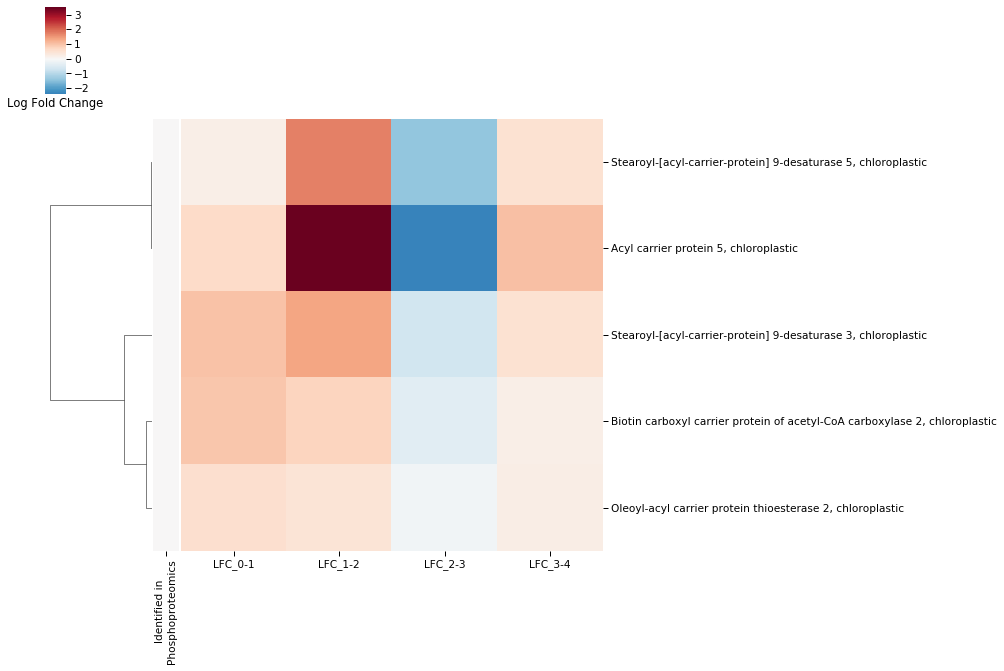

In [6]:
selectClusterPlot(lfc_frame_dict.get('EB'),
                  'Q9LF05 Q9LLC1 Q9M879 Q9SV64 O04652',
                  'LipidMetabolism',
                 metric= 'correlation')

Clustermap of starch metabolic process proteins in SQ

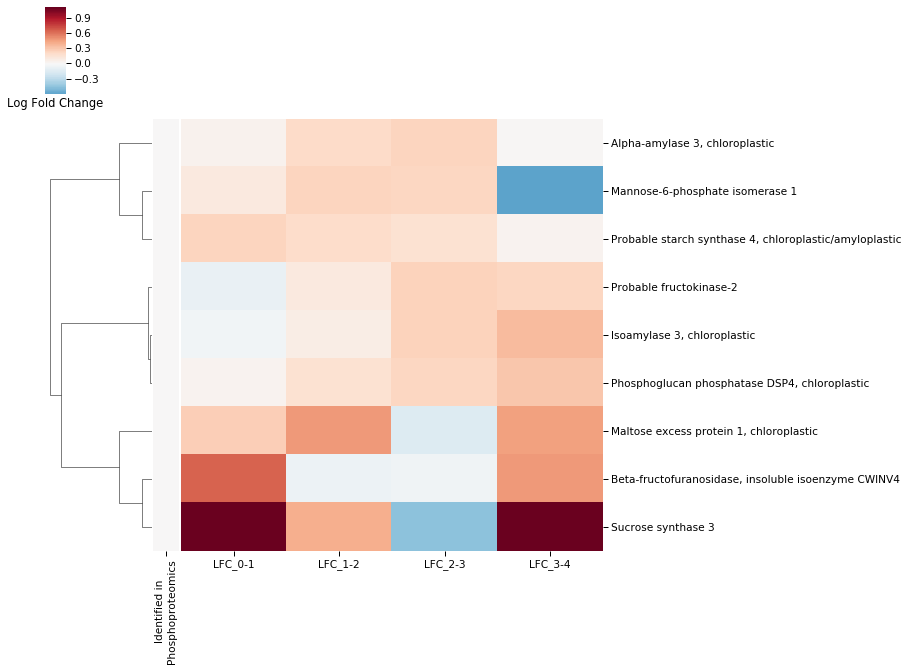

In [52]:
selectClusterPlot(lfc_frame_dict.get('SQ'), 'Q8W413 Q9M884 Q9M0S5 Q9LF50 Q9M111 Q94A41 Q9LNE3 Q0WVX5 Q9FEB5', 'CarbohydrateMetabolicProcess+DSP4_ARATH', metric='correlation')
# not so usefull as line plots with this small number of  proteins

Cellular Nitrogen Metabollic Compound Process in LF

In [17]:
selectClusterPlot(lfc_frame_dict.get('LF'),
                  'SIGB_ARATH RL302_ARATH R18A1_ARATH Q8LDU0_ARATH RS253_ARATH Q8S8D2_ARATH TFB4_ARATH IF32_ARATH IF4A2_ARATH RL372_ARATH RPD6A_ARATH CHR35_ARATH RK35_ARATH Q9M8M9_ARATH Q9LVK6_ARATH NUCL1_ARATH ASF1B_ARATH RL192_ARATH NYC1_ARATH PFKA2_ARATH RU2B1_ARATH MD36A_ARATH SWA1_ARATH RL40A_ARATH APE1L_ARATH MRE11_ARATH RS30_ARATH Q9SMX4_ARATH RPB6B_ARATH DMS3_ARATH Q9FNH2_ARATH Q9ZQC0_ARATH RR31_ARATH Q9XIA6_ARATH RS18_ARATH MSH2_ARATH FPG_ARATH TAF9_ARATH NRPBA_ARATH RK9_ARATH CLH2_ARATH KU80_ARATH Q67Z79_ARATH EFGM1_ARATH DIM1A_ARATH Q8L8R4_ARATH RT02_ARATH RL81_ARATH RPS1_ARATH NRPB7_ARATH RT13_ARATH RLA23_ARATH RS173_ARATH', 'LF_CellularNitrogenCompundMetabollicProcess',
                  longformat=True) 

> <ipython-input-16-261f377190b3>(11)selectClusterPlot()
      9 
     10     set_trace()
---> 11     matrix = df.loc[proteins.split(' ')]
     12     matrix = matrix.set_index('Protein Name')
     13     matrix.index.name = ""

ipdb> n
KeyError: "None of [Index(['SIGB_ARATH', 'RL302_ARATH', 'R18A1_ARATH', 'Q8LDU0_ARATH',\n       'RS253_ARATH', 'Q8S8D2_ARATH', 'TFB4_ARATH', 'IF32_ARATH',\n       'IF4A2_ARATH', 'RL372_ARATH', 'RPD6A_ARATH', 'CHR35_ARATH',\n       'RK35_ARATH', 'Q9M8M9_ARATH', 'Q9LVK6_ARATH', 'NUCL1_ARATH',\n       'ASF1B_ARATH', 'RL192_ARATH', 'NYC1_ARATH', 'PFKA2_ARATH',\n       'RU2B1_ARATH', 'MD36A_ARATH', 'SWA1_ARATH', 'RL40A_ARATH',\n       'APE1L_ARATH', 'MRE11_ARATH', 'RS30_ARATH', 'Q9SMX4_ARATH',\n       'RPB6B_ARATH', 'DMS3_ARATH', 'Q9FNH2_ARATH', 'Q9ZQC0_ARATH',\n       'RR31_ARATH', 'Q9XIA6_ARATH', 'RS18_ARATH', 'MSH2_ARATH', 'FPG_ARATH',\n       'TAF9_ARATH', 'NRPBA_ARATH', 'RK9_ARATH', 'CLH2_ARATH', 'KU80_ARATH',\n       'Q67Z79_ARATH', 'EFGM1_ARATH', 'DIM1

BdbQuit: 

Gene Expression in LF

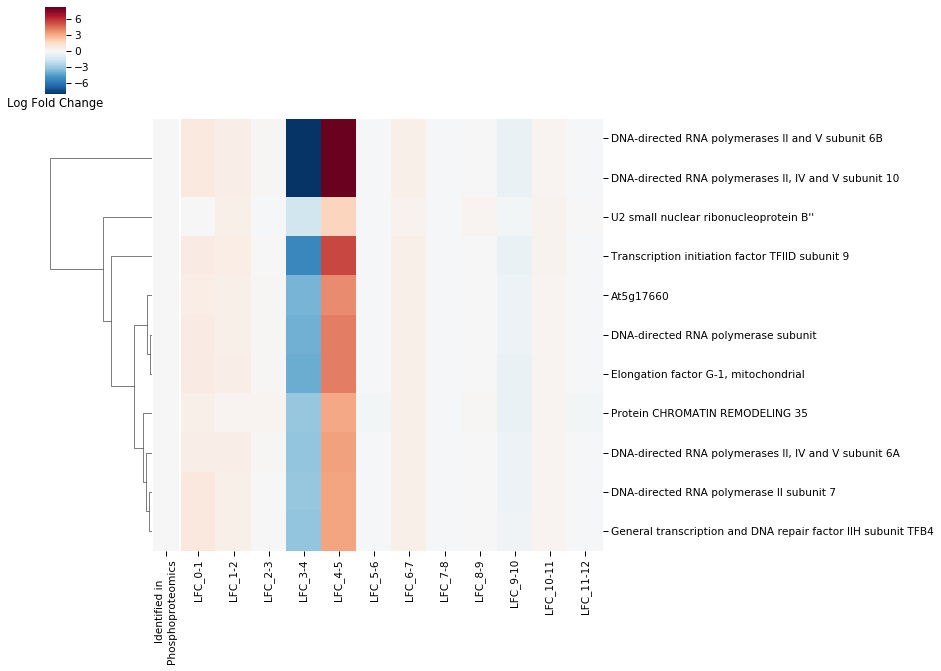

In [57]:
selectClusterPlot(lfc_frame_dict.get('LF'),
                  'Q9ZQC0 P38421 O22922 Q8L8R4 Q9SJ96 Q8LFJ6 Q9FJ98 Q8LF41 Q9C641 Q9SIW2 Q9SYH2',     
                  'LF_GeneExpressionLimited',
                  longformat=False,
                  metric='euclidean')

Embryo Development in LF

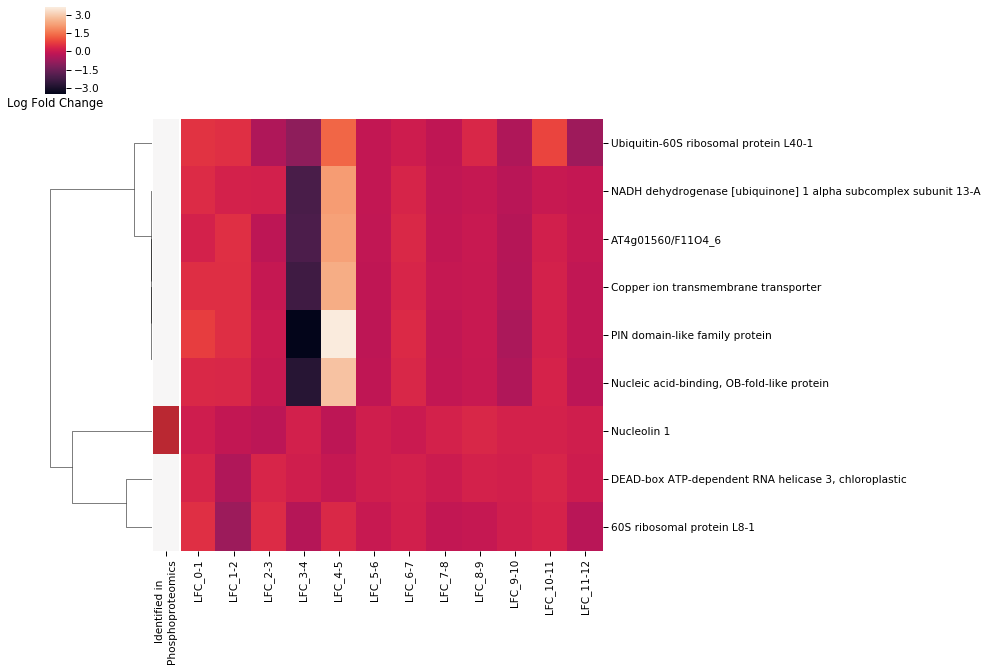

In [14]:
selectClusterPlot(lfc_frame_dict.get('LF'),
                 'Q9M125 Q8LG21 Q8L8C2 B9DHA6 Q9FVQ1 Q8L7S8 Q8RWA7 P46286 Q9XIA6',
                 'LF_EmbryoDevelopment', metric='correlation')

FL_SmallMoleculeMetabolicProcess

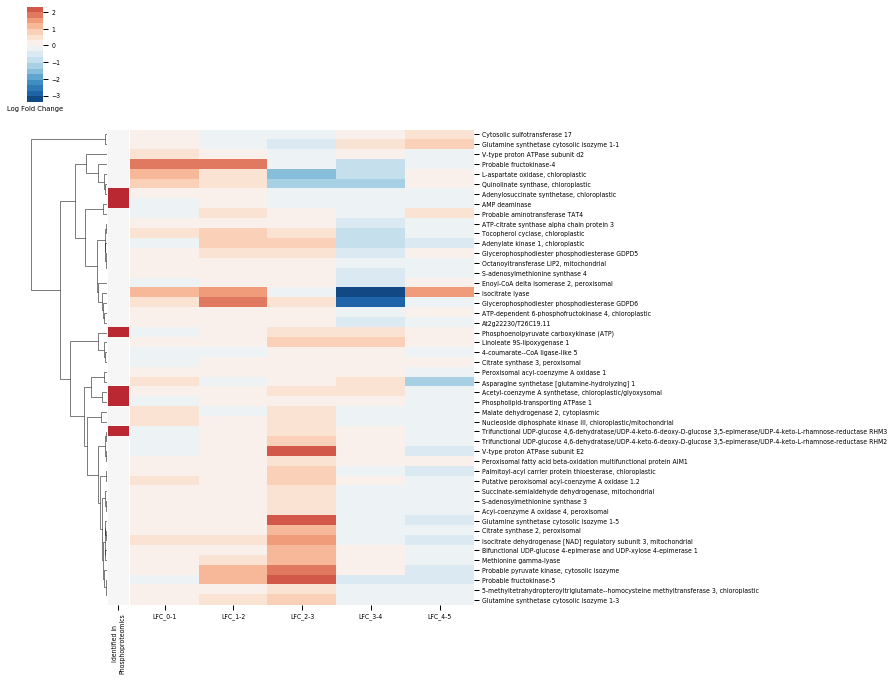

In [59]:
selectClusterPlot(lfc_frame_dict.get('FL'),
                 'Q84P21 Q9C9Z8 Q9SJL8 Q9SJH7 B9DGD6 Q9SD81 O80452 Q9SXP7 Q8GXW5 Q8VYP2 Q9LH76 Q9SAK4 Q9C907 Q9LPG6 P28297 Q9FKG3 O23299 P98204 O80526 Q9FZ80 Q9LXS6 Q9SJE2 Q0WNZ5 Q9FGS4 Q06327 Q96329 Q94AY1 Q96529 Q9M1B9 Q9T074 O65202 O82616 P57106 Q9ZPI6 Q9LUT2 Q9LVI8 Q42605 Q9SGU9 O65595 Q9ZQP2 P49078 O49203 Q9LHA4 Q94FY7 Q9SIE3 Q56WN1 O81796 Q9ZUU1',
                 'FL_SmallMoleculeMetabolicProcess',
                 True,
                 metric='correlation'
                 )

Pollen Development in FL

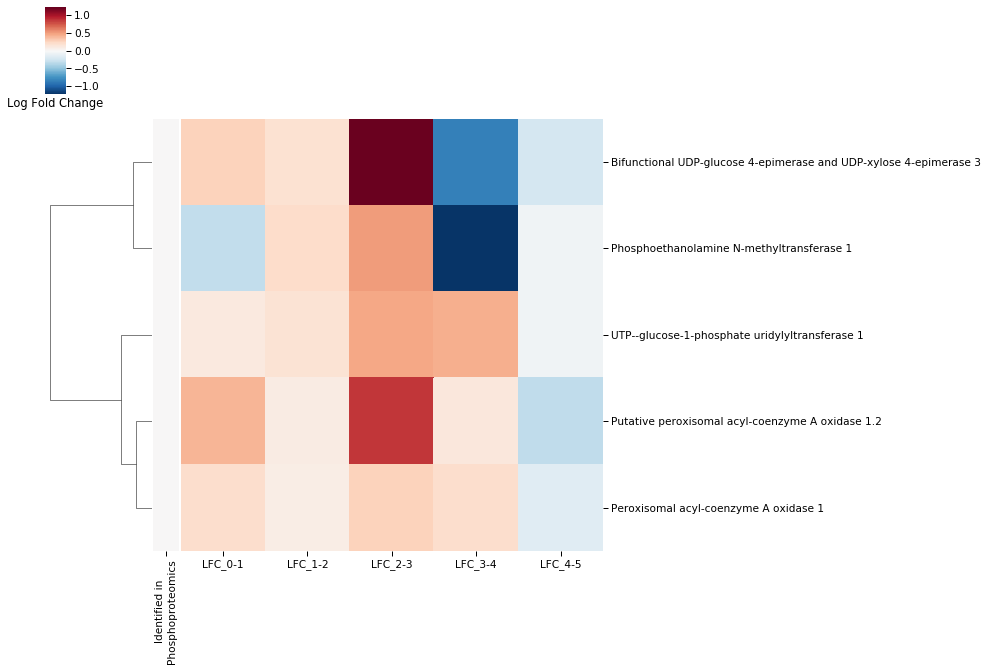

In [60]:
selectClusterPlot(lfc_frame_dict.get('FL'),
                 'Q9ZQP2 O65202 Q8LDN8 Q9FR44 P57751',
                 'FL_PollenDevelopment',
                 metric='correlation')

Transport FL

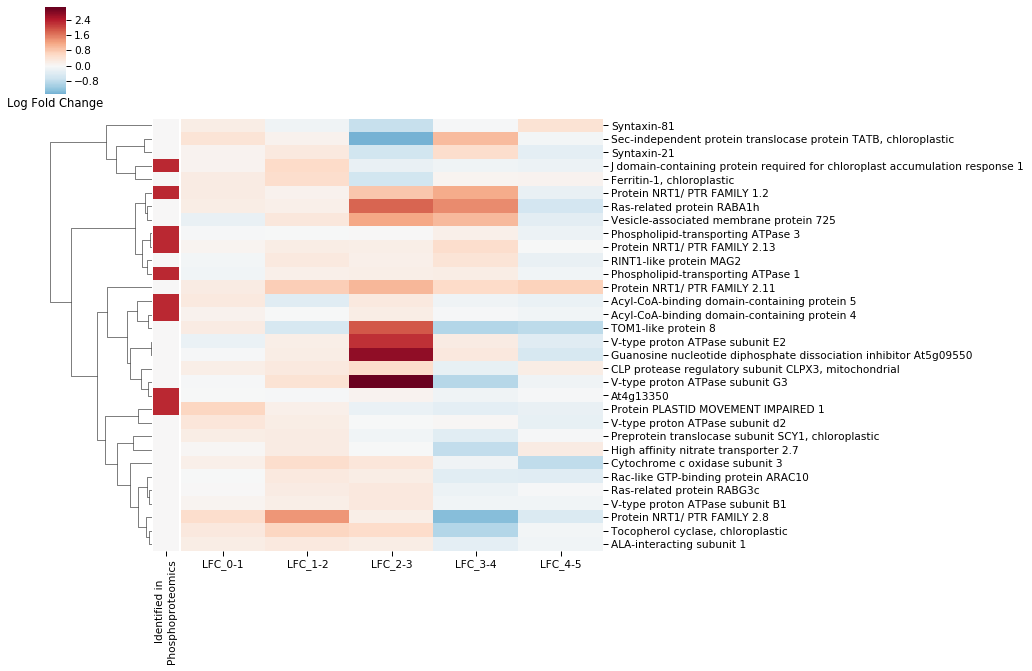

In [61]:
selectClusterPlot(lfc_frame_dict.get('FL'),
                 'Q1PEX3 Q9MA55 Q9M817 Q9C9Z8 Q66GN9 Q9LW76 Q9LV10 Q9XIE6 Q9XH75 Q9SZH0 Q9C8E6 Q3E8X3 P59277 Q8RX77 Q39233 Q9C9Q4 Q9LXC0 Q38885 Q9LYK2 Q9STU3 O48850 P98204 Q9LHA4 Q94FY7 Q9C9Y1 P11574 P92514 Q8RWD9 Q9LTW0 Q8W4K6 Q39101 O82481',
                 'FL_Transport',
                 metric='correlation')

FL Transprot Limited

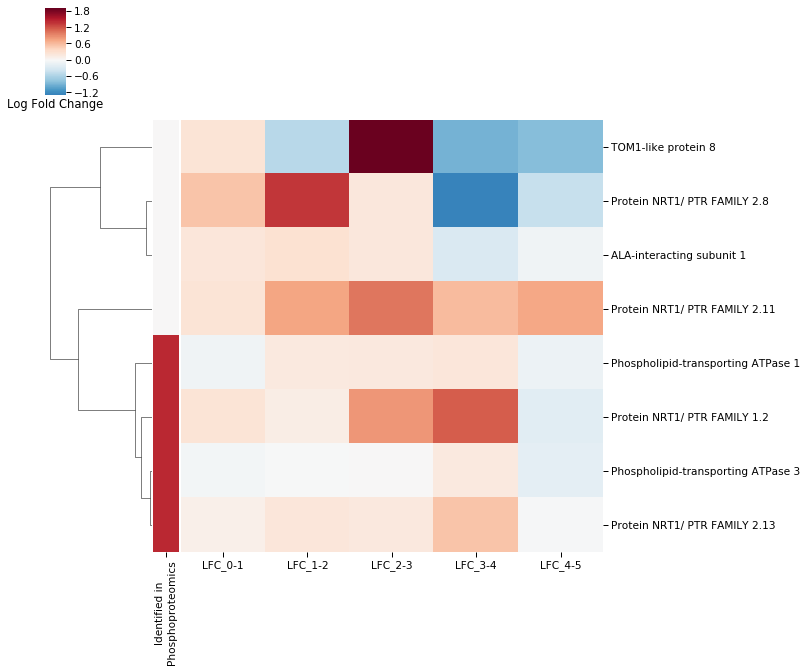

In [63]:
selectClusterPlot(lfc_frame_dict.get('FL'),
                 'Q9XIE6 P98204 Q9C9Y1 Q8RX77 Q3E8X3 Q9LTW0 Q9M817 Q9LV10',
                 'FL_Transport',
                 metric='correlation')

Clustermaps for Tissue Specific Proteins

EB


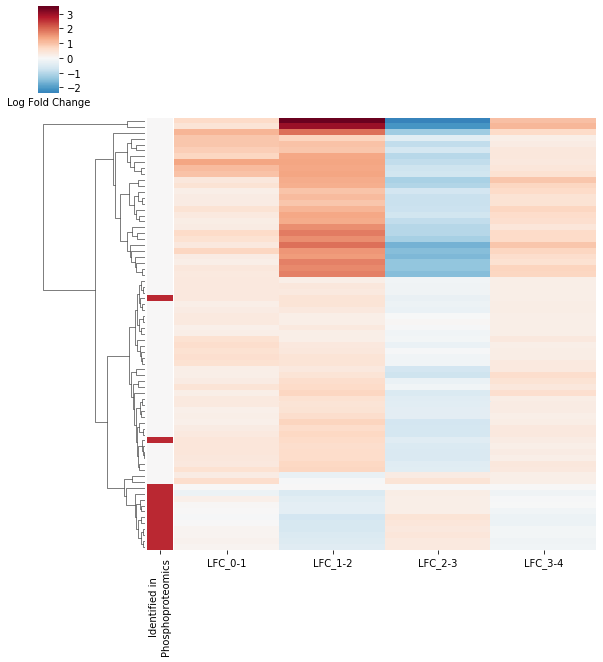

FL


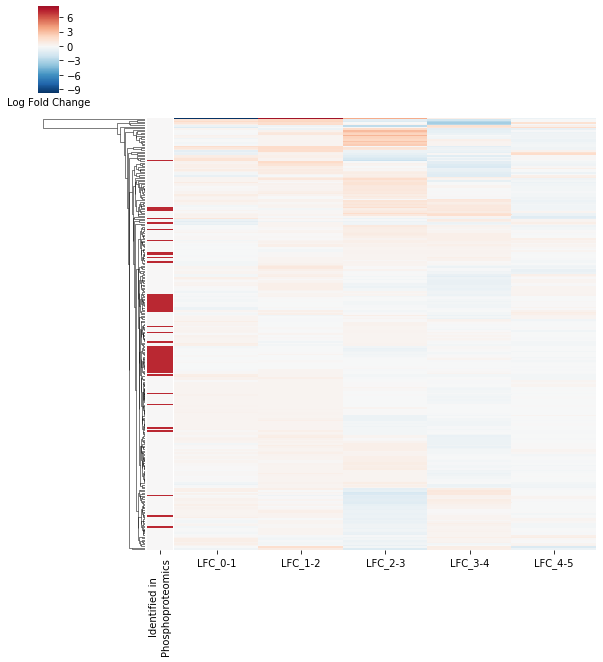

LF


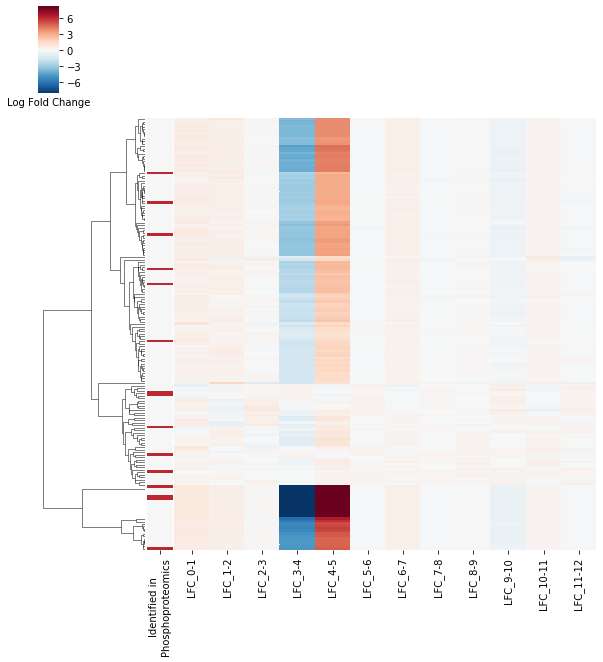

SQ


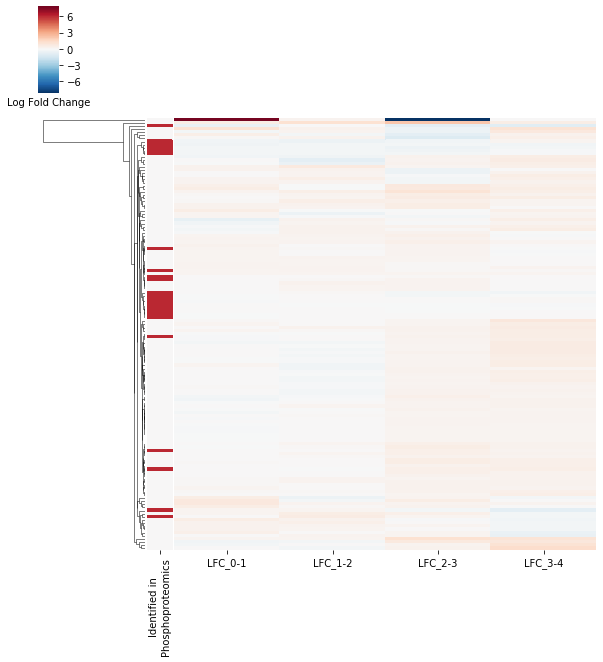

In [5]:
for name in lfc_frame_dict:
    if name == 'SH':
        continue
    print(name)
    phosmarker = lfc_frame_dict.get(name)["ISPHOS"].squeeze()
    phosmarker = phosmarker.rename('Identified in\nPhosphoproteomics')

    count = 0
    matrix = lfc_frame_dict.get(name).copy()
    matrix.index.name = ""
    
    phos_colors = [[0.9690888119953864, 0.9664744329104191, 0.9649365628604383], [0.7284890426758939, 0.15501730103806227, 0.1973856209150327]]
    phosmarker_colors = phosmarker.map({0: phos_colors[0], 1: phos_colors[1]})
    fig = sb.clustermap(matrix.iloc[:,:-3], col_cluster=False, row_cluster=True, method="average", metric="euclidean",
                        row_colors=phosmarker_colors, yticklabels=False, cmap=sb.color_palette("RdBu_r", 200), center= 0)
    
    plt.xlabel("Log Fold Change")
    plt.savefig('./Plots/{}_clustermap.png'.format(name), dpi=200, bbox_inches= 'tight')
    plt.show()

Clustermap of Proteins Shared between Tissues

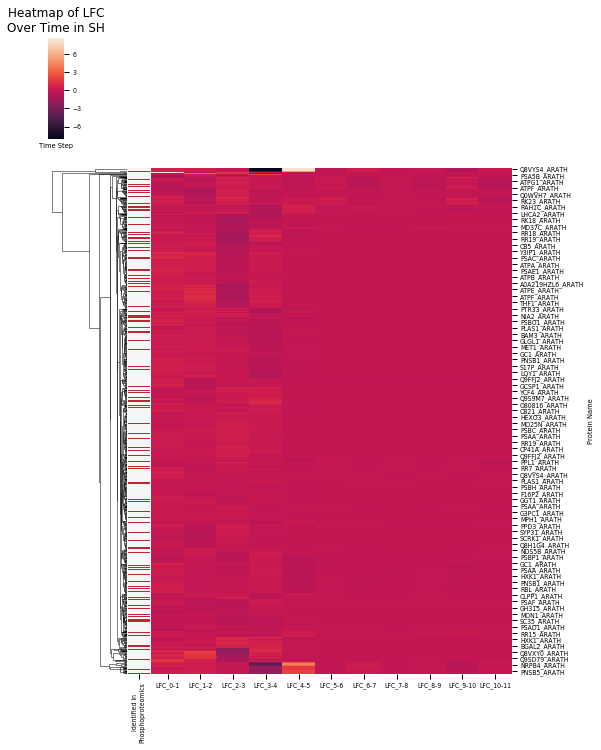

In [224]:
matrix = shared_node_table.copy()
matrix = matrix.rename(columns={"NAME": "Protein Name"})
matrix = matrix.set_index("Protein Name")
matrix = matrix.iloc[:,5:17]
matrix = matrix.fillna(0)

phosmarker = matrix["ISPHOS"].squeeze()
phosmarker = phosmarker.rename('Identified in\nPhosphoproteomics')

# isphos indicator colors and column
phos_colors = [[0.9690888119953864, 0.9664744329104191, 0.9649365628604383], [0.7284890426758939, 0.15501730103806227, 0.1973856209150327]]
phosmarker_colors = phosmarker.map({0: phos_colors[0], 1: phos_colors[1]})

# plot
sb.set_context("paper", font_scale=0.7)
fig = sb.clustermap(lfc_frame.iloc[:,1:], col_cluster=False, row_cluster=True, 
              method="average", metric="euclidean", row_colors=phosmarker_colors, figsize=(8.3, 11.7), yticklabels=False)
plt.title("Heatmap of LFC\nOver Time in SH", fontsize=12)
plt.xlabel("Time Step")
fig.savefig('./Plots/SH_clustermap.png', dpi=200)
plt.show()

## Clustermap of Specific Function in Tissue Shared Proteins

In [25]:
def sharedClusterPlot(df, proteins, filename, longformat= False, metric= 'euclidean', restricted= True):
    # loop over sh using tissue names and make a plot for each sourcetisse
    fun_matrix = 0
    if restricted:
        fun_matrix = df.loc[[p for p in proteins.split() if len(df.loc[[p]]) == 4]]
        # print the set of proteins available in all four tissues for possible other uses 
        print(set(fun_matrix.index.to_list()))
    
    for name in ['EB', 'FL', 'LF', 'SQ']:
        fun_matrix = df.loc[proteins.split()]
        print(name)
        tissue_matrix = fun_matrix.loc[fun_matrix['SOURCETISSUE'] == name]
        # skip tissues not cotaining data for this set of proteins
        if len(tissue_matrix) == 0:
            continue
        # remove all LFC columns not populated in this tissue
        tissue_matrix = tissue_matrix.dropna(axis=1)

        # reorder columns to fit selections done in selectClusterMap
        cols = tissue_matrix.columns.tolist()
        cols = cols[1:] + cols[0:1]
        tissue_matrix = tissue_matrix[cols] 
        # create clustermap
        selectClusterPlot(tissue_matrix, ' '.join(tissue_matrix.index.to_list()), 'SH_{}_{}'.format(name, filename), longformat=longformat, metric=metric)


{'P25858', 'Q9LZP9', 'O23553', 'Q94BT0', 'Q8L7S6', 'P25857', 'P46283', 'Q9MB58', 'Q9SID0', 'Q9SCY0', 'Q9LD57', 'Q9LFA6', 'Q42525', 'P25856', 'Q9MA79'}
EB


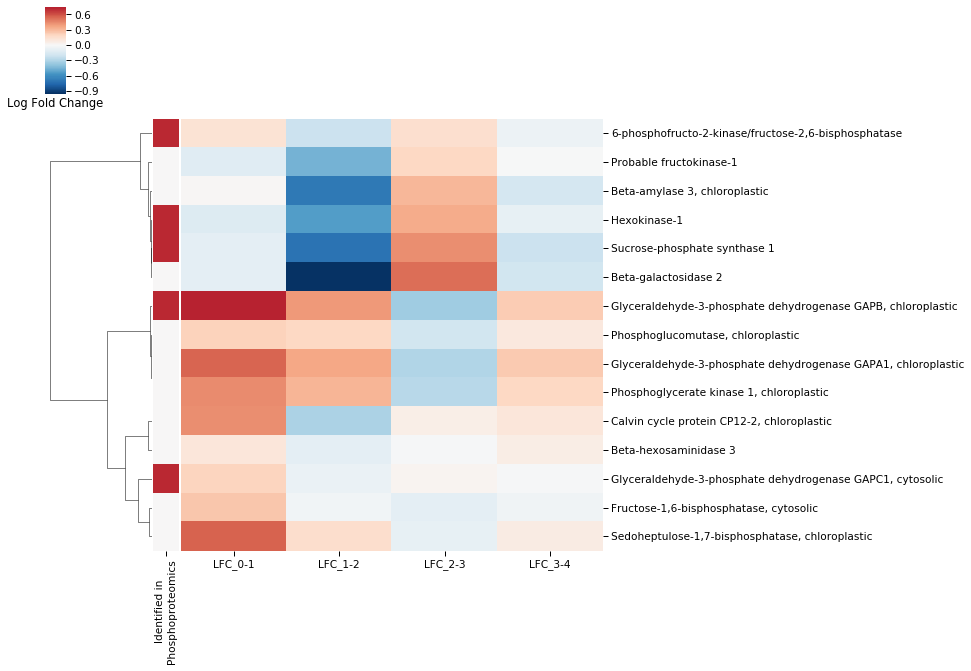

FL


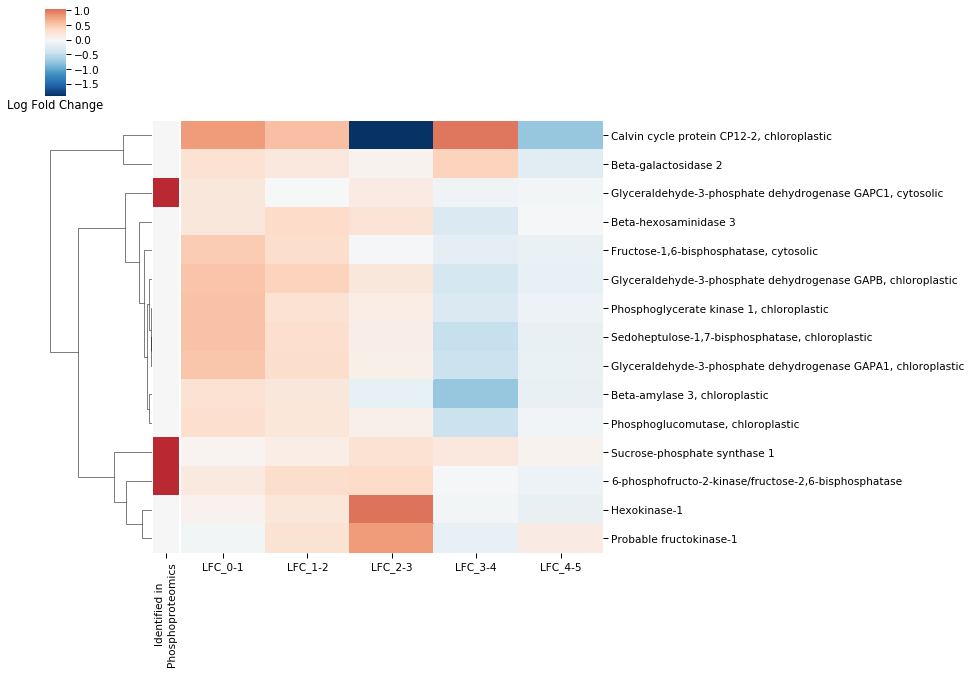

LF


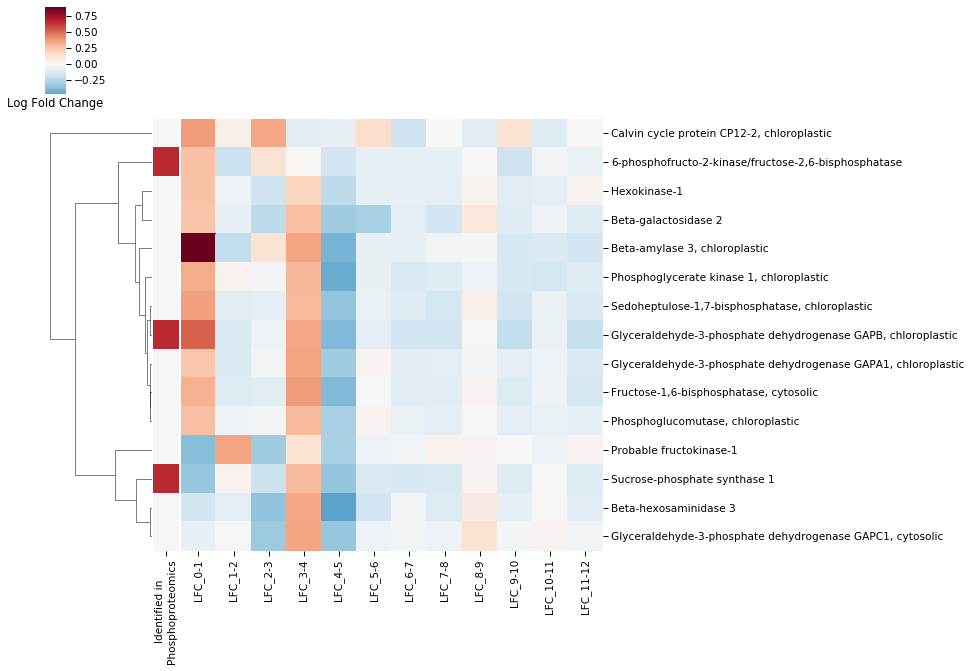

SQ


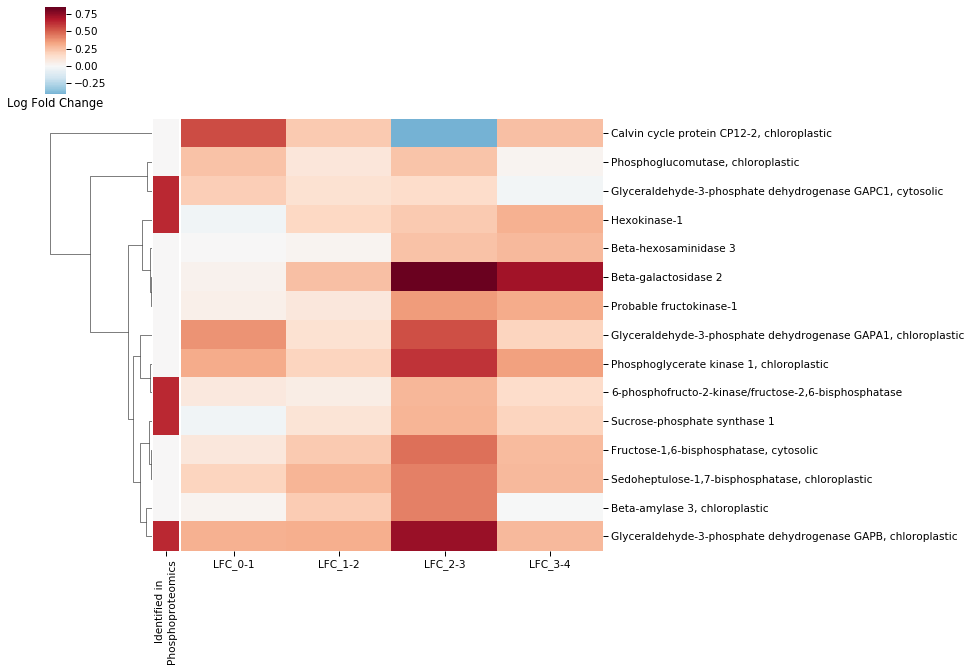

In [20]:
sharedClusterPlot(lfc_frame_dict.get('SH'), 
                  'Q9LZP9 Q9MA79 P46283 Q8L7S6 O23553 Q42525 Q94BT0 Q9LFA6 Q9SID0 Q9SCY0 P25858 P25857 P25856 Q9LD57 Q9MB58',
                  'RestrictedCarbohydrateMetabolicProcess',
                  metric= 'correlation')

{'P46283', 'Q9S9N6', 'P23321', 'Q9ZVL6', 'Q9SHR7', 'Q01908', 'P25856', 'Q9SHE8', 'Q9M591', 'Q9XF89', 'Q9SUI5', 'Q9LMQ2', 'Q8LBP6', 'P25857', 'Q9S7W1', 'Q9M158', 'P27202', 'P82538', 'Q9LZP9', 'Q9S7H1', 'Q9SYW8', 'Q07473', 'Q9SUI4', 'Q9SA56', 'Q9S7N7', 'Q9S841', 'Q9SSS9', 'Q9SKT0'}
EB


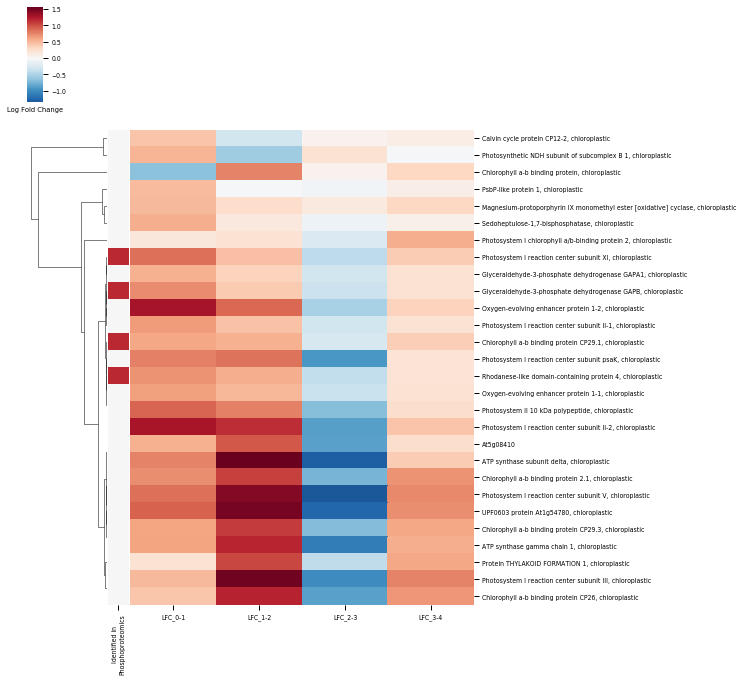

FL


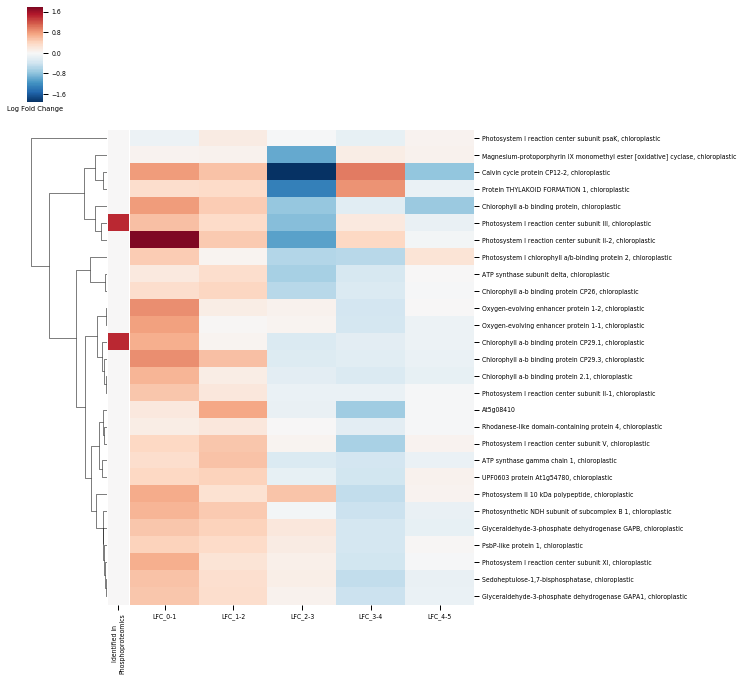

LF


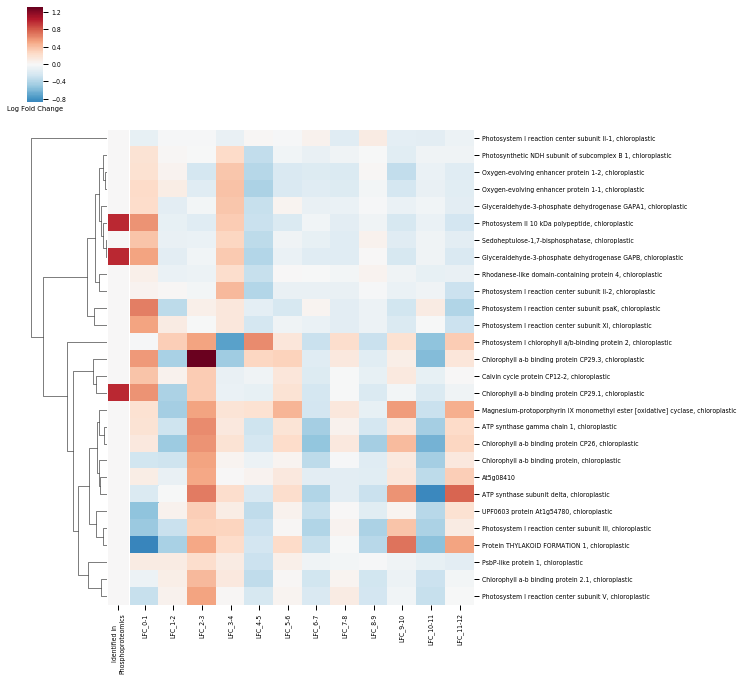

SQ


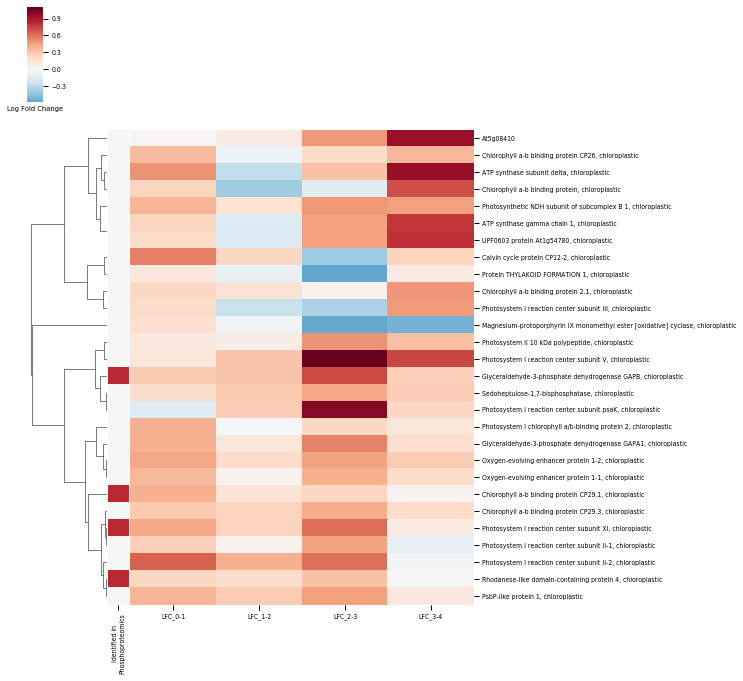

In [22]:
sharedClusterPlot(lfc_frame_dict.get('SH'), 
                  'Q9LZP9 Q9SHR7 Q9S7W1 Q9S841 Q07473 Q9M158 Q8LBP6 Q9M591 Q01908 P23321 P82538 P27202 P46283 Q42029 Q9ZVL6 Q9SSS9 Q9SYW8 Q9SHE8 Q9XF89 Q9SUI5 Q9S9N6 Q9LMQ2 Q9SA56 Q9S7N7 Q9SUI4 Q9S7H1 P25857 P25856 Q9SKT0',
                  'RestrictedPhotosynthesis',
                  metric= 'correlation',
                  longformat= True)